In [1]:
# Regression Models
%matplotlib inline
#%matplotlib widget
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
from collections import Counter
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import (AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor,
RandomForestRegressor, VotingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor)

# Preprocessing
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.preprocessing import LabelEncoder, StandardScaler ,OneHotEncoder, MinMaxScaler, PolynomialFeatures

# model_selection
from sklearn.model_selection import (train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold, 
learning_curve, cross_val_predict, cross_validate, permutation_test_score, validation_curve, RandomizedSearchCV)

# Metrics
from sklearn.metrics import (accuracy_score, cohen_kappa_score, confusion_matrix, mean_squared_error, r2_score,
root_mean_squared_error, recall_score, roc_auc_score, roc_curve, mean_absolute_error, auc, classification_report, f1_score)

#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000) 

In [2]:
cln = ['price_deflator', # GNP.deflator: GNP implicit price deflator (1954=100)
       'gross_national_product', # - GNP: Gross National Product.
       'unemployed', # - Unemployed: number of unemployed.
       'people_in_the_army', # - Armed.Forces: number of people in the armed forces.
       'population', # - Population: ‘noninstitutionalized’ population ≥ 14 years of age.
       'year', # - Year: the year (time).
       'employed'] # - Employed: number of people employed.

df = pd.read_csv('longley.csv', names=cln, engine='pyarrow')
df.head()

,price_deflator,gross_national_product,unemployed,people_in_the_army,population,year,employed
0,83.0,234.289,235.6,159.0,107.608,1947,60.323
1,88.5,259.426,232.5,145.6,108.632,1948,61.122
2,88.2,258.054,368.2,161.6,109.773,1949,60.171
3,89.5,284.599,335.1,165.0,110.929,1950,61.187
4,96.2,328.975,209.9,309.9,112.075,1951,63.221


In [6]:
# Round values
df['gross_national_product'] = round(df['gross_national_product'], 2)
df['population'] = round(df['population'], 2) 
df['employed'] = round(df['employed'], 2)

In [8]:
# Data Integrity Check
print("Big Query Statistics:")
print('-' * 127)
print(f"🚣‍♀️ DataFrame Shape: {df.shape}")
print('-' * 127)
print(f"Columns to list:\n{df.columns.tolist()}")
print('-' * 127)
print(f"📊 DataFrame Info: {df.info(memory_usage='deep')}")
print('-' * 127)
print(f"📈 DataFrame Distribution:\n {df.describe()}")

missing_values = df.isna().sum()

if len(missing_values) < 0:
    print("❌ Missing data for following columns:")
else:
    print(f"✅ No missing values for df:\n{missing_values}")

Big Query Statistics:
-------------------------------------------------------------------------------------------------------------------------------
🚣‍♀️ DataFrame Shape: (16, 7)
-------------------------------------------------------------------------------------------------------------------------------
Columns to list:
['price_deflator', 'gross_national_product', 'unemployed', 'people_in_the_army', 'population', 'year', 'employed']
-------------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price_deflator          16 non-null     float64
 1   gross_national_product  16 non-null     float64
 2   unemployed              16 non-null     float64
 3   people_in_the_army      16 non-null     float64
 4   populat

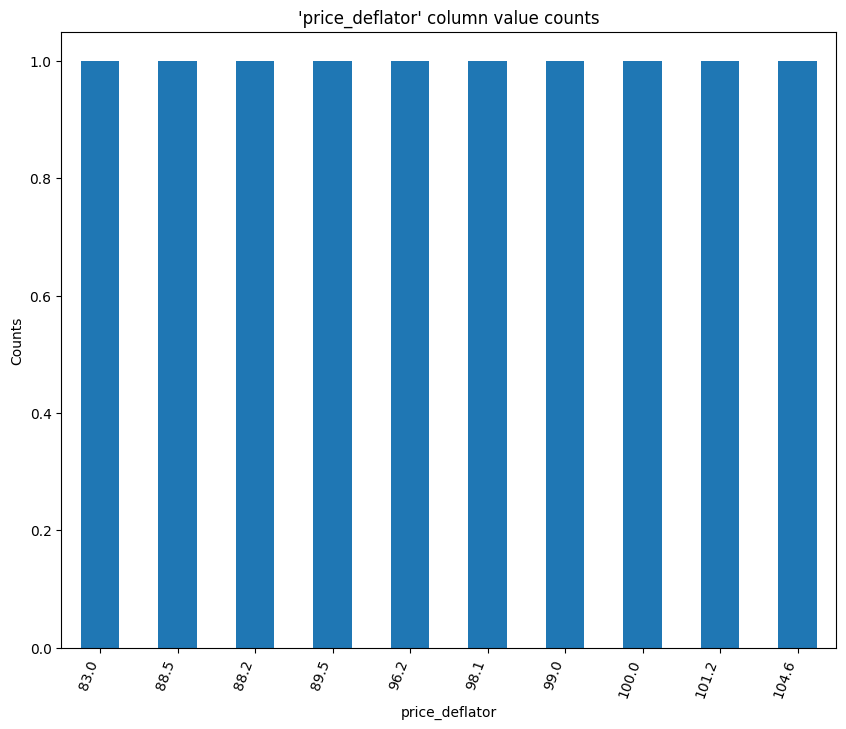

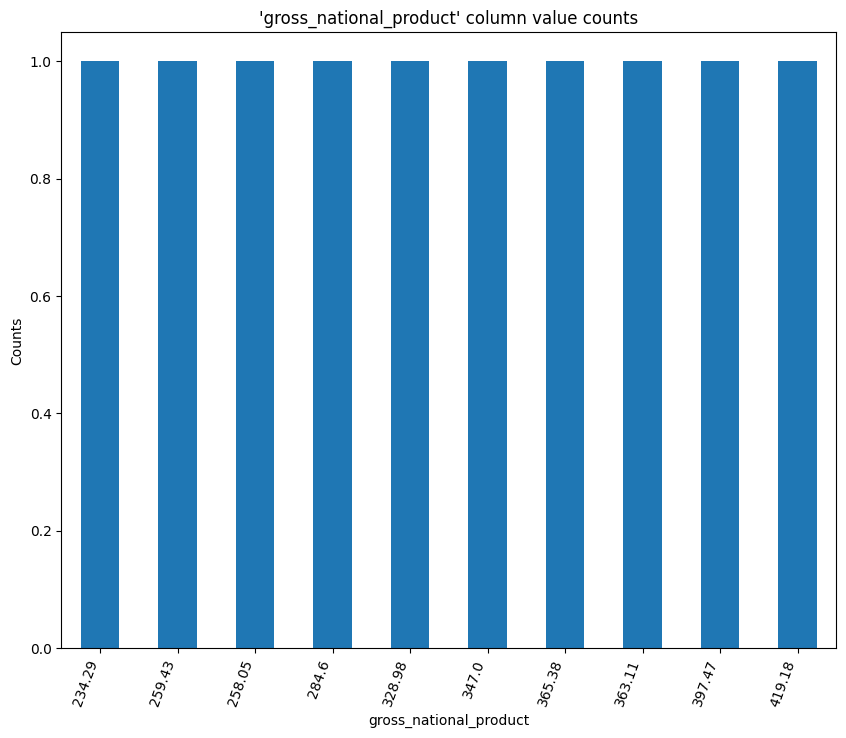

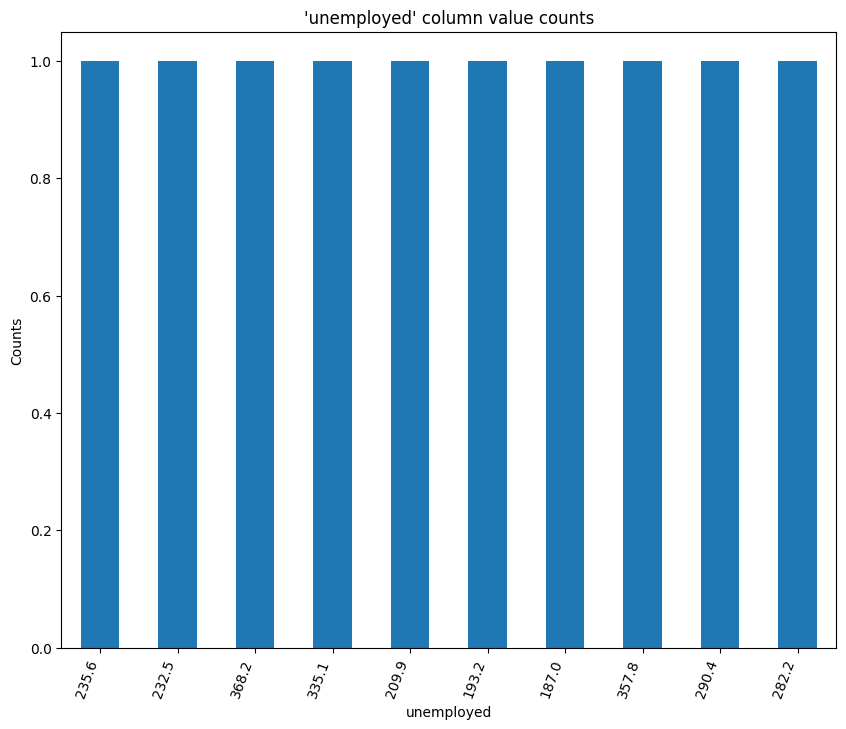

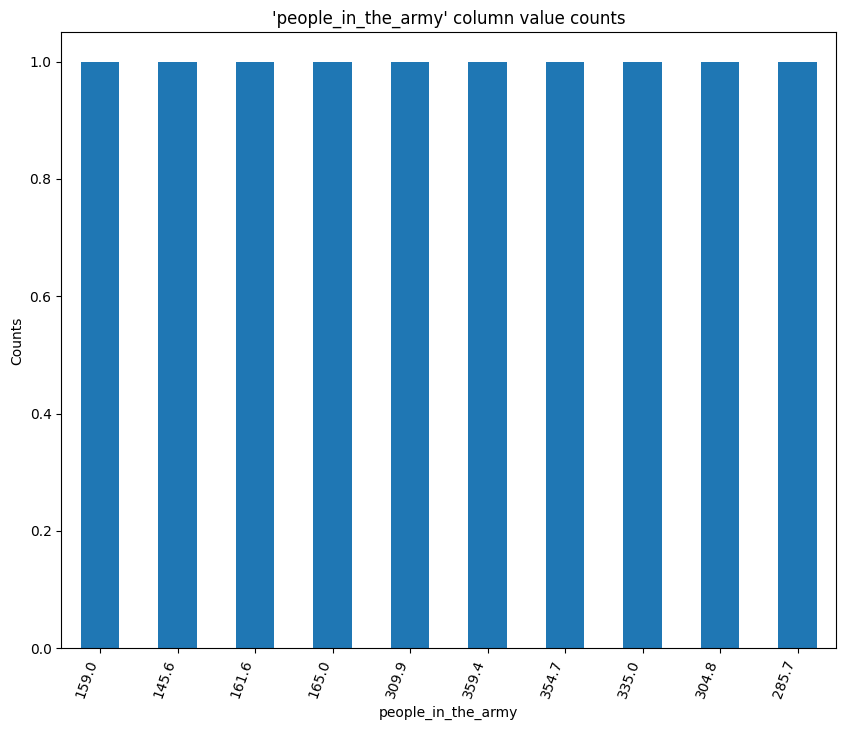

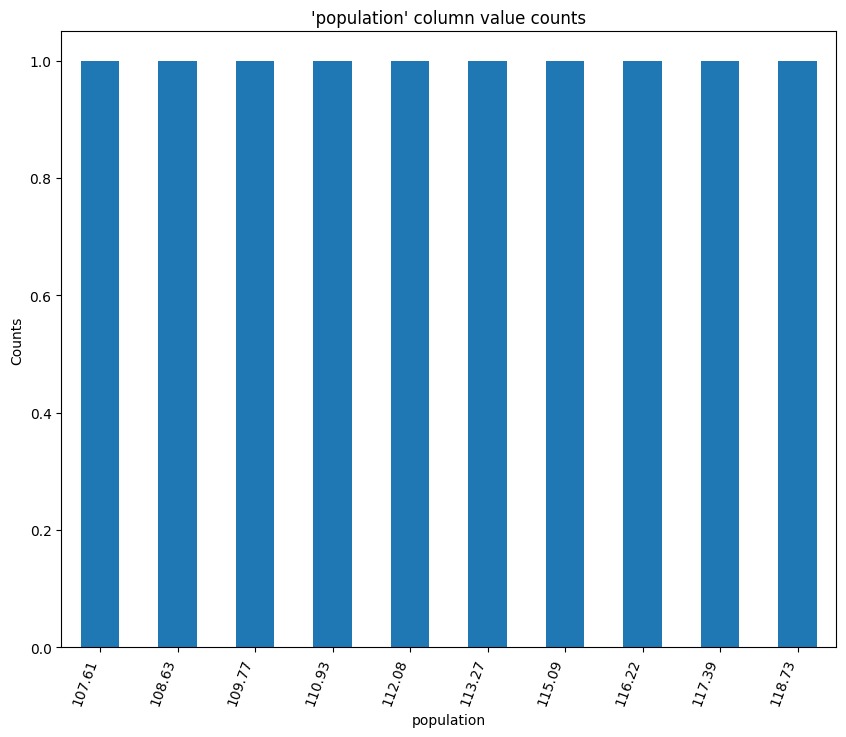

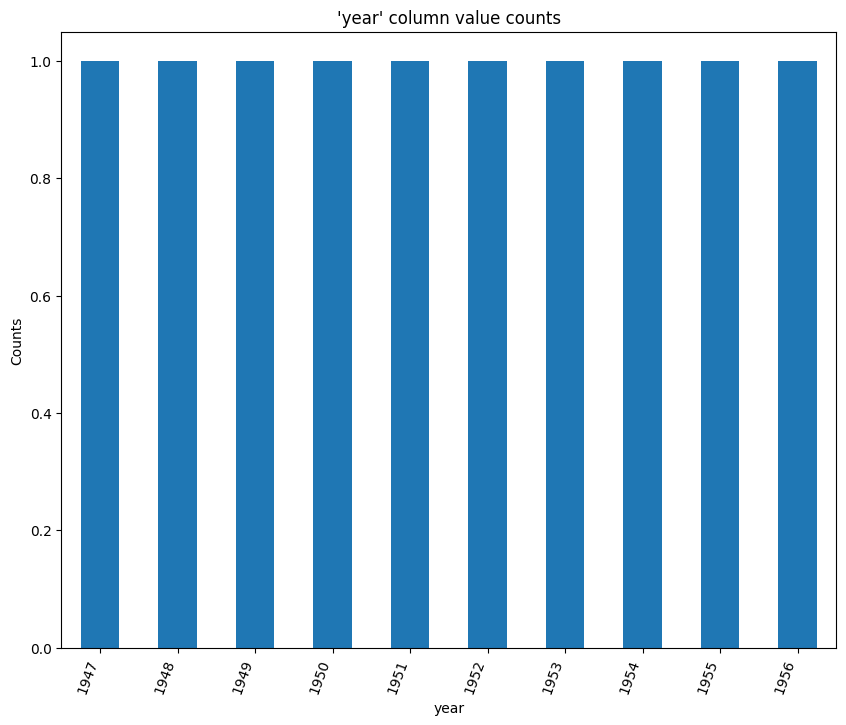

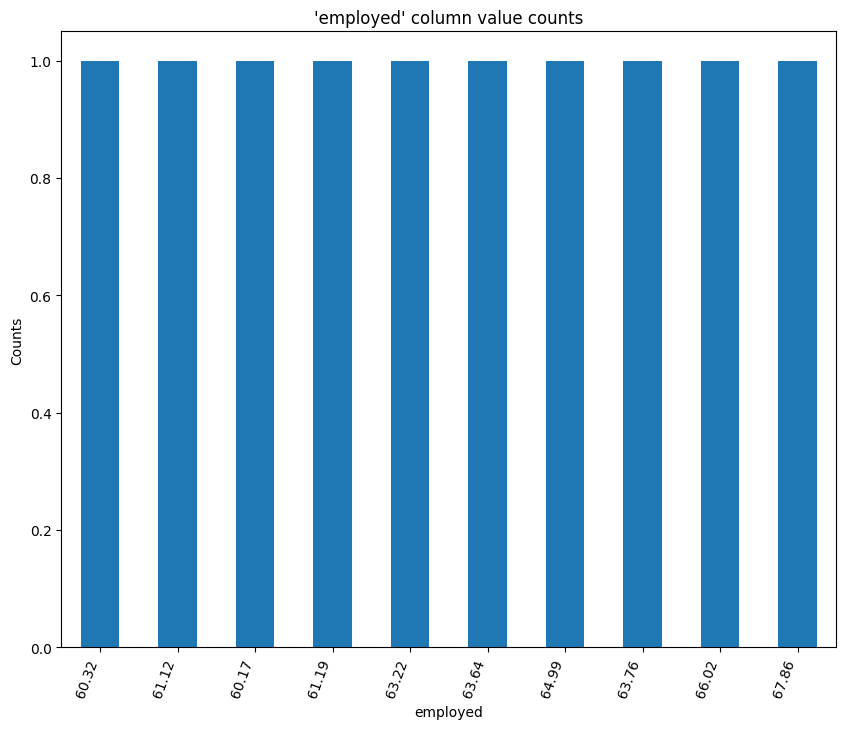

In [9]:
# Data Distribution
# Exploratory Data Analysis
def eda_plot(column, topn=10):
    plt.figure(figsize=(10, 8))
    df[column].value_counts().nlargest(topn).plot(kind='bar')
    plt.title(f"'{column}' column value counts")
    plt.ylabel("Counts")
    plt.xticks(rotation = 70, ha='right')
    plt.show()

columns = df.columns

for column in columns:
    eda_plot(column)

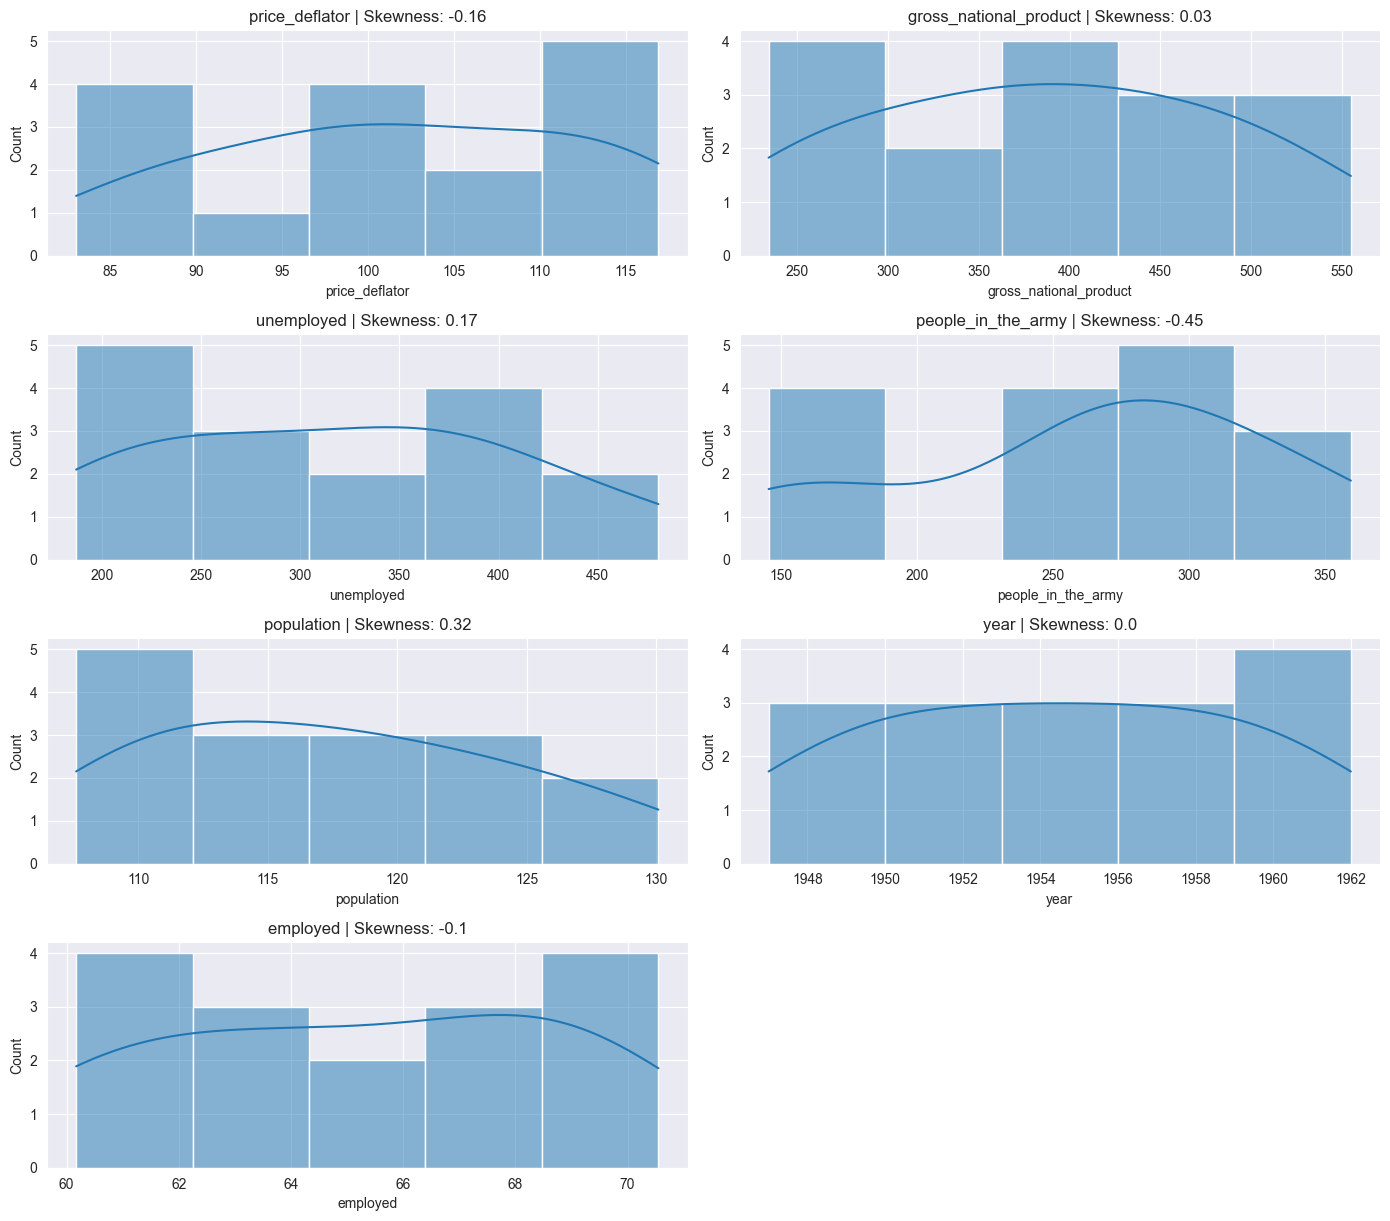

In [10]:
# Kernel Density Plot for understanding variance in the dataset
sns.set_style("darkgrid")
numerical_columns = df.select_dtypes(include=["int", "float"]).columns 
plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(df[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(df[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

In [11]:
df.head()

,price_deflator,gross_national_product,unemployed,people_in_the_army,population,year,employed
0,83.0,234.29,235.6,159.0,107.61,1947,60.32
1,88.5,259.43,232.5,145.6,108.63,1948,61.12
2,88.2,258.05,368.2,161.6,109.77,1949,60.17
3,89.5,284.60,335.1,165.0,110.93,1950,61.19
4,96.2,328.98,209.9,309.9,112.08,1951,63.22


## LinearRegression

Dataset shape: (16, 6)
Feature names: Index(['gross_national_product', 'unemployed', 'people_in_the_army', 'population', 'year', 'employed'], dtype='object')

X Train shape: (12, 6)
Y Train shape: (12,)
X Test shape: (4, 6)
Y Test shape: (4,)
-------------------------------------------------------------------------------------------------------------------------------
=== Linear Regression Tuning Examples ===
=== Feature Correlation Analysis ===


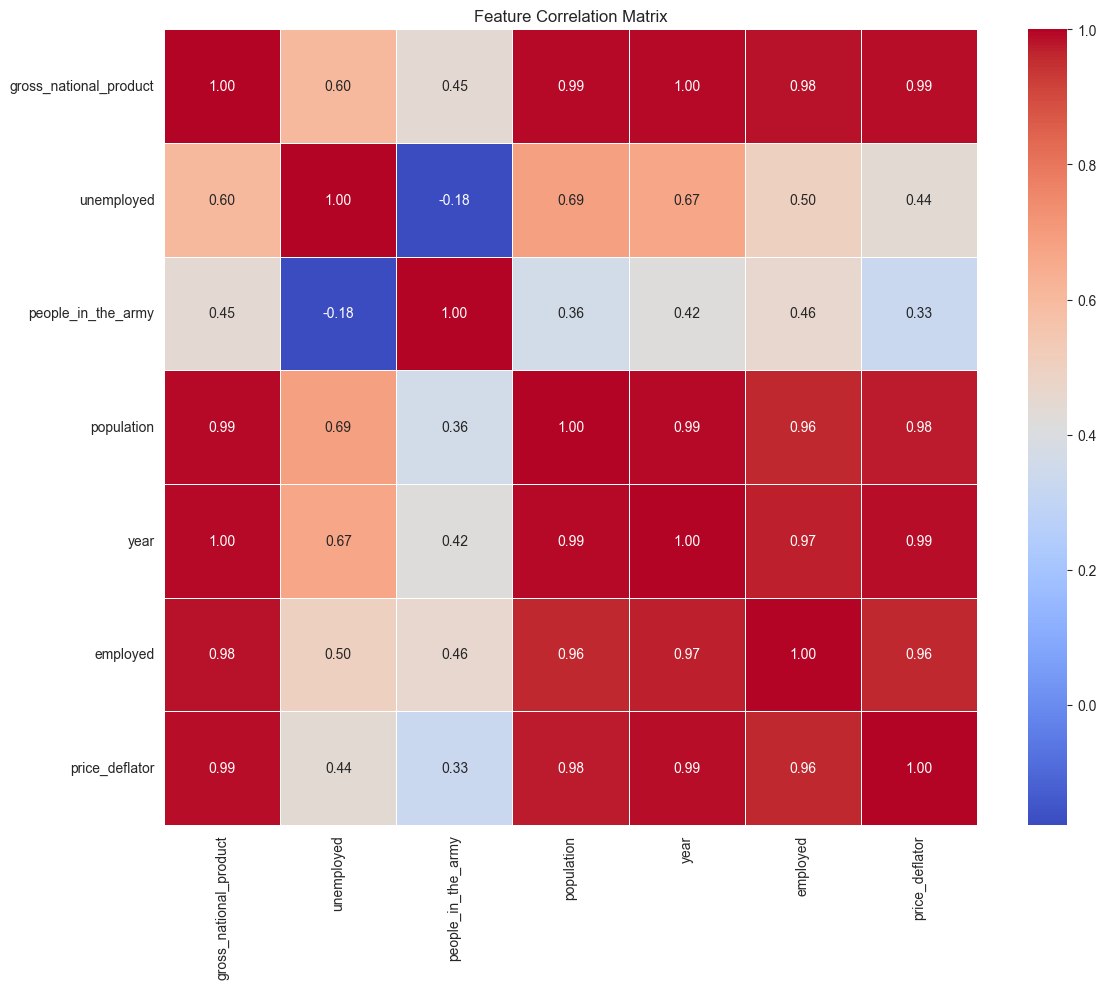

Feature correlation with target (price_deflator):
price_deflator            1.000000
year                      0.989352
gross_national_product    0.988213
population                0.976037
employed                  0.962012
unemployed                0.441220
people_in_the_army        0.328743
Name: price_deflator, dtype: float64
-------------------------------------------------------------------------------------------------------------------------------
=== Cross-Validation ===
Cross-Validation MSE: 2.5775 ± 1.0006
Cross-Validation MAE: 1.3332 ± 0.4173
Cross-Validation R²: 0.9519 ± 0.0313
-------------------------------------------------------------------------------------------------------------------------------
=== Basic Linear Regression ===
MSE test set: 1.9117
MSE train set: 0.7190

R² Score test: 0.9876
R² Score train: 0.9912

MAE test set: 0.9216
MAE train set: 0.6858

Coefficients: [ 0.24070545  0.04363016  0.01942122 -1.59754844 -1.52456874  0.64542534]
Intercept: 3114.3586

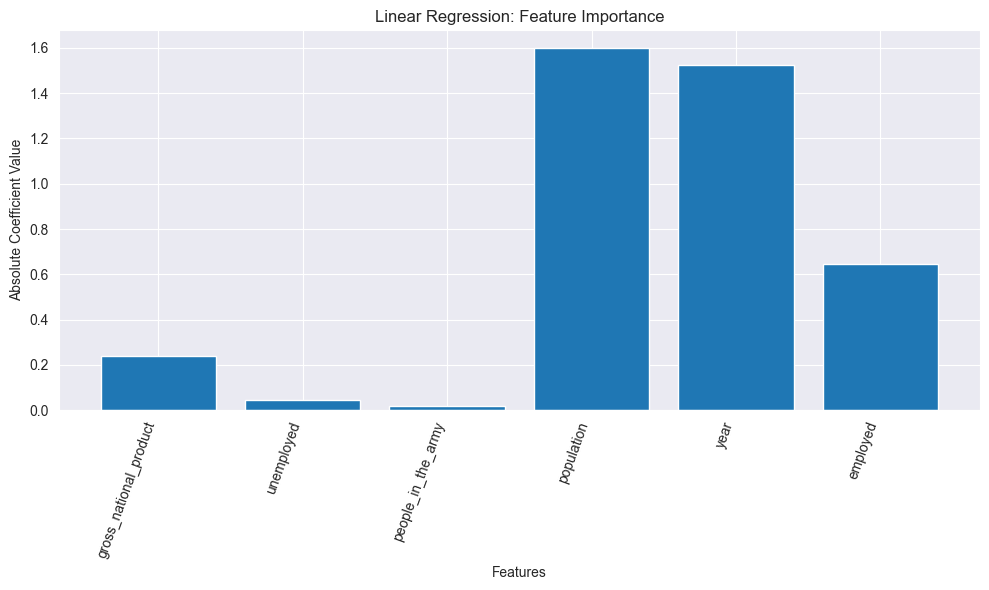

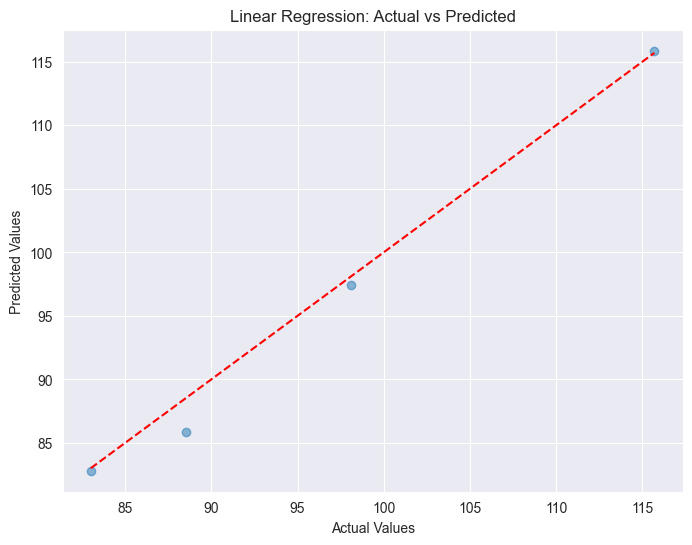

=== Scaled Linear Regression ===
MSE test set: 1.9117
MSE train set: 0.7190

R² Score test: 0.9876
R² Score train: 0.9912

MAE test set: 0.9216
MAE train set: 0.6858

Selected Features Coef_: ['gross_national_product' 'unemployed' 'people_in_the_army' 'population'
 'year' 'employed']
-------------------------------------------------------------------------------------------------------------------------------


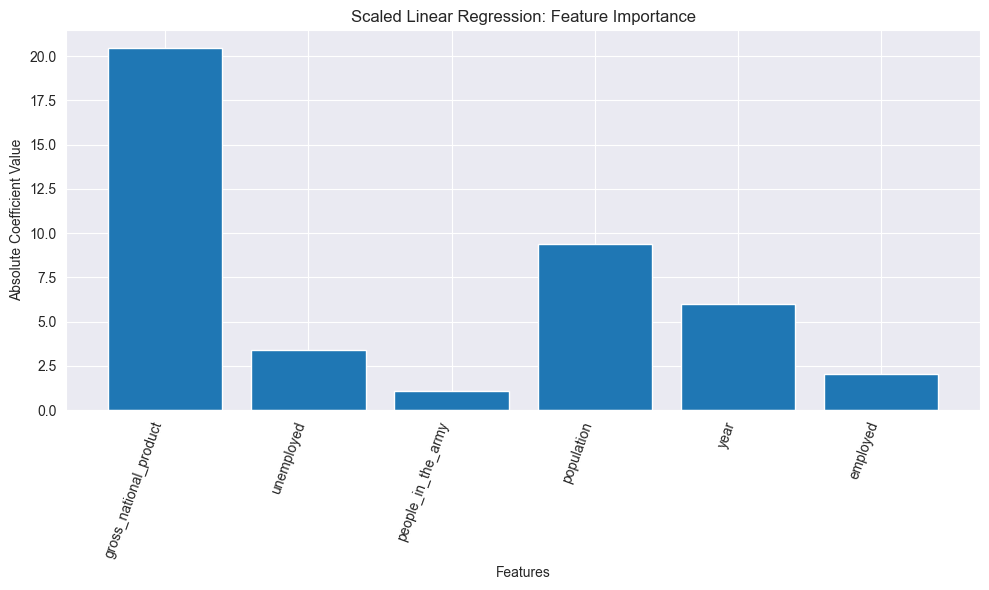

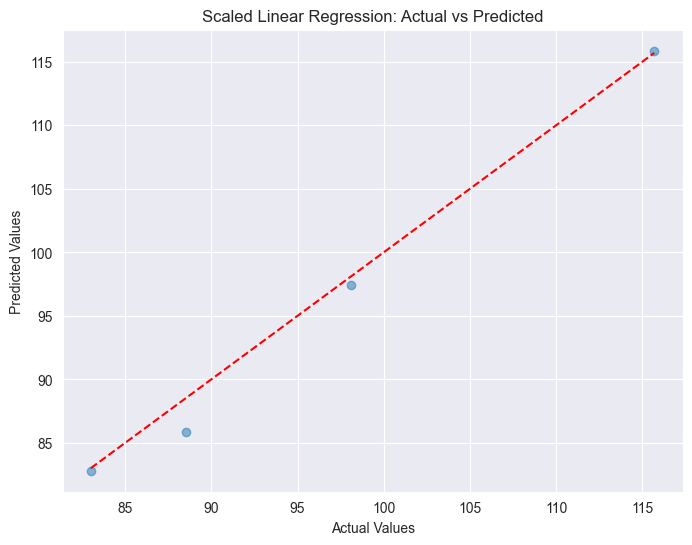

=== Feature Selection (SelectKBest) ===
MSE test set: 1.7141
MSE train set: 0.8338

R² Score test: 0.9889
R² Score train: 0.9898

MAE test set: 1.0236
MAE train set: 0.7328

Selected Features Selector : ['gross_national_product' 'unemployed' 'population' 'year' 'employed']
-------------------------------------------------------------------------------------------------------------------------------


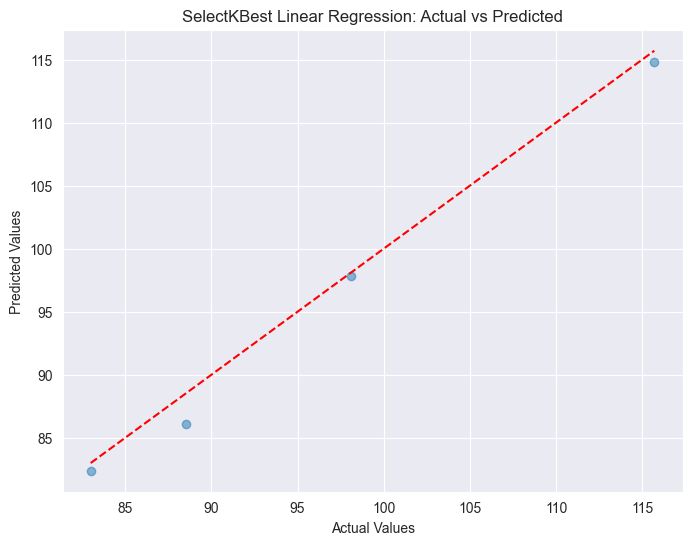

=== Feature Selection (RFE) ===
MSE test set: 1.7141
MSE train set: 0.8338

R² Score test: 0.9889
R² Score train: 0.9898

MAE test set: 1.0236
MAE train set: 0.7328

Selected Features Selector : ['gross_national_product' 'unemployed' 'population' 'year' 'employed']
-------------------------------------------------------------------------------------------------------------------------------


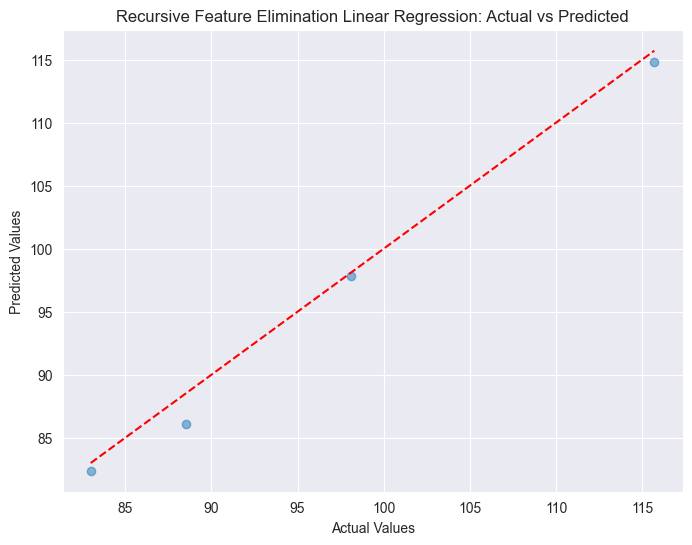

=== Polynomial Regression ===
MSE test set: 29.8780
MSE train set: 0.0000

R² Score test: 0.8064
R² Score train: 1.0000

MAE test set: 4.6775
MAE train set: 0.0000

Selected Features Coef_: ['gross_national_product' 'unemployed' 'people_in_the_army' 'population'
 'year' 'employed' 'gross_national_product^2'
 'gross_national_product unemployed'
 'gross_national_product people_in_the_army'
 'gross_national_product population' 'gross_national_product year'
 'gross_national_product employed' 'unemployed^2'
 'unemployed people_in_the_army' 'unemployed population' 'unemployed year'
 'unemployed employed' 'people_in_the_army^2'
 'people_in_the_army population' 'people_in_the_army year'
 'people_in_the_army employed' 'population^2' 'population year'
 'population employed' 'year^2' 'year employed' 'employed^2']
-------------------------------------------------------------------------------------------------------------------------------


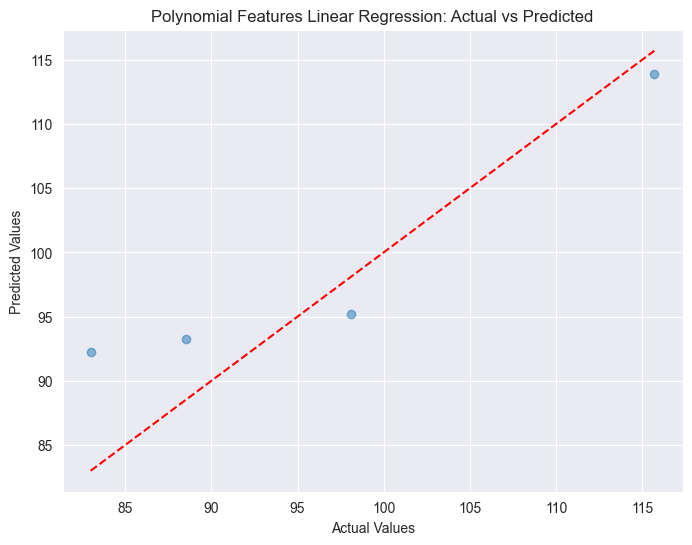

=== Ridge Regression ===
MSE test set:  2.0306
MSE train set: 0.8156

R² Score test: 0.9868
R² Score train:0.9900

MAE test set:  0.9219
MAE train set: 0.7835

Best alpha:    0.0100

Selected Features Coef_: ['gross_national_product' 'unemployed' 'people_in_the_army' 'population'
 'year' 'employed']
-------------------------------------------------------------------------------------------------------------------------------


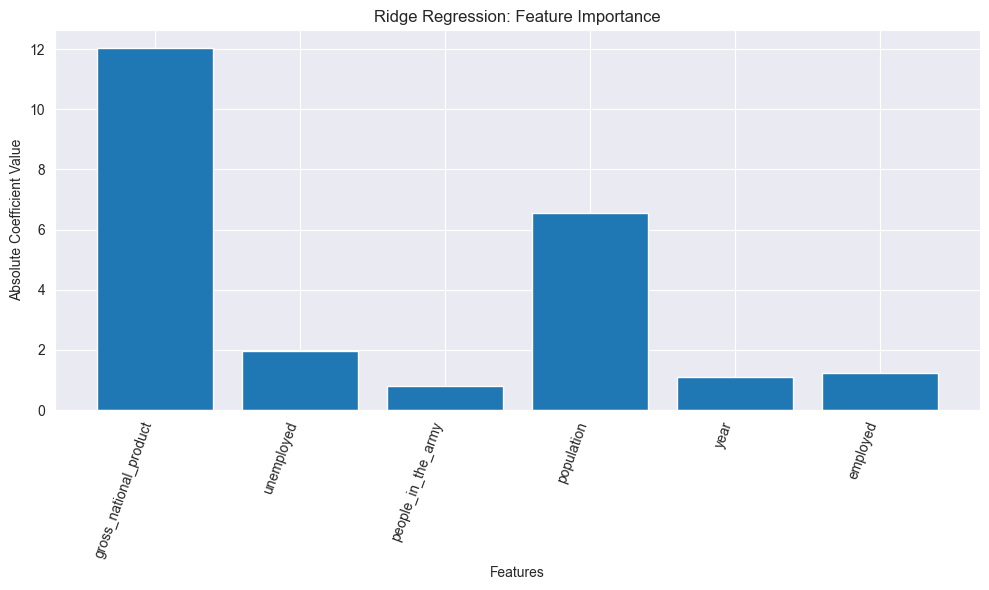

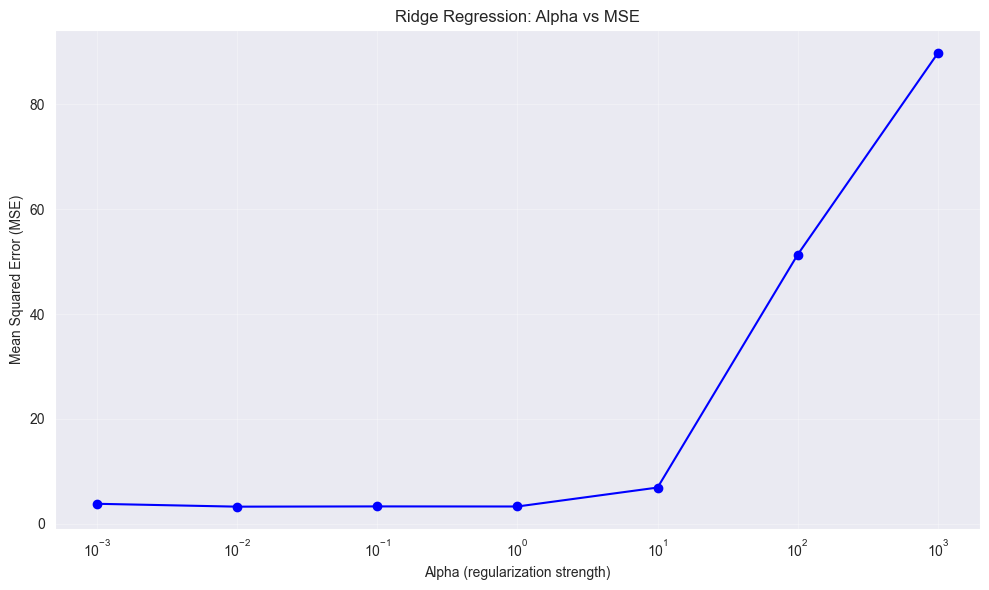

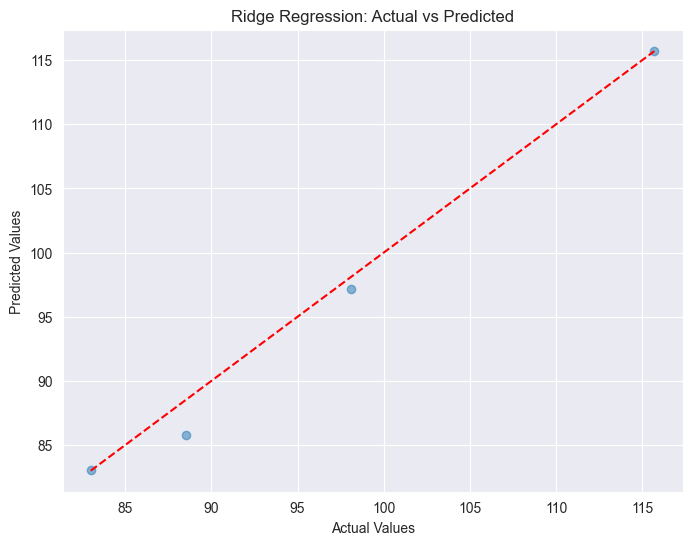

-------------------------------------------------------------------------------------------------------------------------------
=== Lasso Regression ===
MSE test set: 1.8121
MSE train set: 0.8235

R² Score test: 0.9883
R² Score train: 0.9899

MAE test set: 0.9438
MAE train set: 0.7899

Best alpha: 0.01

Selected features: ['gross_national_product' 'unemployed' 'people_in_the_army' 'population'
 'employed']
-------------------------------------------------------------------------------------------------------------------------------


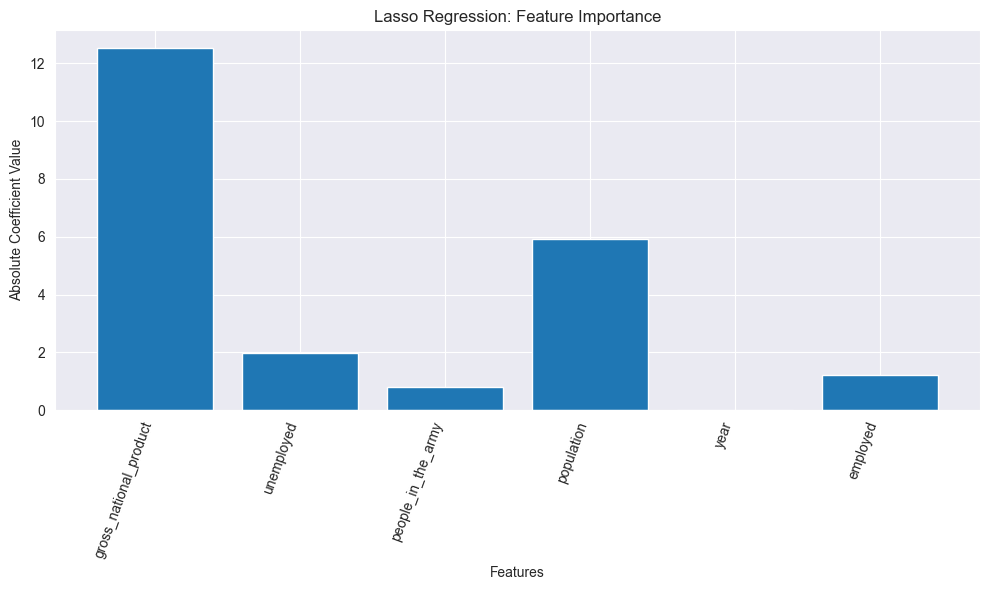

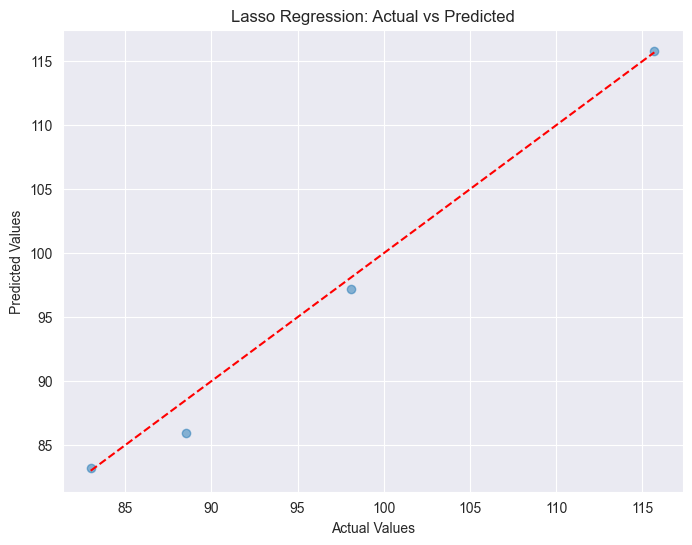

-------------------------------------------------------------------------------------------------------------------------------
=== Elastic Net Regression ===
MSE test set: 2.0359
MSE train set: 0.8248

R² Score test: 0.9868
R² Score train: 0.9899

MAE test set: 0.9359
MAE train set: 0.7898

Best parameters: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.1}

Selected Features Coef_: ['gross_national_product' 'unemployed' 'people_in_the_army' 'population'
 'year' 'employed']
-------------------------------------------------------------------------------------------------------------------------------


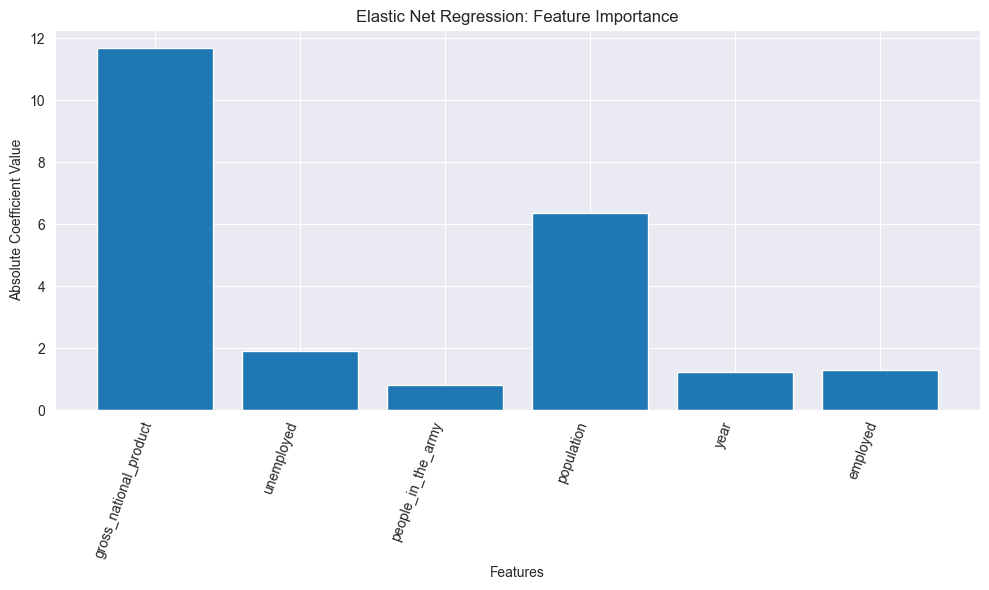

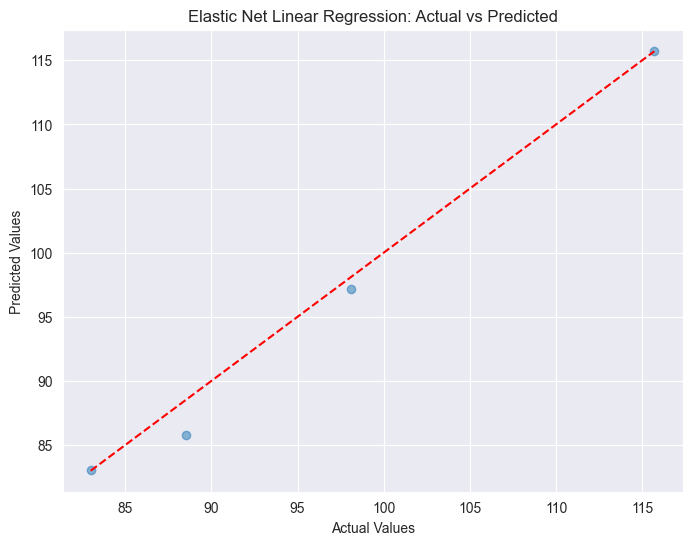

-------------------------------------------------------------------------------------------------------------------------------
=== Model Comparison ===
                                 MAE       MSE        R²
Polynomial Regression      29.877992  0.806404  4.677479
Elastic Net                 2.035891  0.986808  0.935931
Ridge Regression            2.030611  0.986843  0.921862
Basic Linear Regression     1.911676  0.987613  0.921587
Scaled Linear Regression    1.911676  0.987613  0.921587
Lasso Regression            1.812097  0.988258  0.943792
Feature Selection (KBest)   1.714068  0.988894  1.023607
Feature Selection (RFE)     1.714068  0.988894  1.023607
-------------------------------------------------------------------------------------------------------------------------------
Best model according to MAE: Polynomial Regression
Best model according to MSE: Polynomial Regression
Best model according to RMSE: Polynomial Regression
Best model according to R2_score: Polynomial Regress

In [13]:
# Set random seed for reproducibility
np.random.seed(42)

# Training & Splitting
X = df.drop(columns=['price_deflator'], axis=1)
y = df['price_deflator']

print("Dataset shape:", X.shape)
print("Feature names:", X.columns)
print() 

# For short dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X Train shape:", X_train.shape)
print("Y Train shape:", y_train.shape)
print("X Test shape:",  X_test.shape)
print("Y Test shape:",  y_test.shape)
print("-" * 127) 

# Basic Linear Regression model
def basic_linear_regression():
    print("=== Basic Linear Regression ===")
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n") 
    print("Coefficients:", model.coef_)
    print("Intercept:", model.intercept_)
    
    # Check which features were selected (non-zero coefficients)
    lr_coef = model.coef_
    selected_features = np.array(X_train.columns)[lr_coef != 0]
    print(f"\nSelected features: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Linear Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Linear Regression: Actual vs Predicted')
    plt.show()

    return model, mse_test, r2_test, mae_test

# Feature Scaling
def scaled_linear_regression():
    print("=== Scaled Linear Regression ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    # Check which features were selected (non-zero coefficients)
    scaled_lr_coef = pipeline.named_steps['regression'].coef_
    selected_features = np.array(X_train.columns)[scaled_lr_coef != 0]
    print(f"Selected Features Coef_: {selected_features}") 
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(scaled_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Scaled Linear Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Scaled Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Feature Selection with SelectKBest
def feature_selection_kbest():
    print("=== Feature Selection (SelectKBest) ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(f_regression, k=5)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train) 

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    selected_features = np.array(X_train.columns)[pipeline.named_steps['selector'].get_support()]
    print(f"Selected Features Selector : {selected_features}")
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('SelectKBest Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Feature Selection with Recursive Feature Elimination (RFE)
def feature_selection_rfe():
    print("=== Feature Selection (RFE) ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', RFE(LinearRegression(), n_features_to_select=5)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    selected_features = np.array(X_train.columns)[pipeline.named_steps['selector'].get_support()]
    print(f"Selected Features Selector : {selected_features}") 
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Recursive Feature Elimination Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Polynomial Features
def polynomial_regression():
    print("=== Polynomial Regression ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}") 

    # Get the polynomial feature names
    poly_features = pipeline.named_steps['poly'].get_feature_names_out(X_train.columns)
    
    # Get coefficients from the regression step
    poly_coef = pipeline.named_steps['regression'].coef_
    
    # Find selected features (non-zero coefficients)
    selected_features = poly_features[poly_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Polynomial Features Linear Regression: Actual vs Predicted')
    plt.show()  
    
    return pipeline, mse_test, r2_test, mae_test

# Regularized Linear Regression - Ridge
def ridge_regression():
    print("=== Ridge Regression ===")
    param_grid = {'ridge__alpha': np.logspace(-3, 3, 7)}
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(random_state=42))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)
    
    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set:  {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train:{r2_train:.4f}\n")
    print(f"MAE test set:  {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    print(f"Best alpha:    {grid_search.best_params_['ridge__alpha']:.4f}")
  
    # Check which features were selected (non-zero coefficients)
    ridge_lr_coef = grid_search.best_estimator_['ridge'].coef_
    selected_features = np.array(X_train.columns)[ridge_lr_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(ridge_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Ridge Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize alpha vs MSE
    plt.figure(figsize=(10, 6))
    results = pd.DataFrame(grid_search.cv_results_)
    alphas = np.array(param_grid['ridge__alpha'])
    scores = -results['mean_test_score']
    plt.semilogx(alphas, scores, 'b-o')
    plt.xlabel('Alpha (regularization strength)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Ridge Regression: Alpha vs MSE')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Ridge Regression: Actual vs Predicted')
    plt.show() 
    print("-" * 127) 
    
    return best_model, mse_test, r2_test, mae_test

# Regularized Linear Regression - Lasso
def lasso_regression():
    print("=== Lasso Regression ===")
    param_grid = {'lasso__alpha': np.logspace(-3, 1, 5)}
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', Lasso(random_state=42, max_iter=10000))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")   
    print(f"Best alpha: {grid_search.best_params_['lasso__alpha']}") 
    
    # Check which features were selected (non-zero coefficients)
    lasso_coef = best_model.named_steps['lasso'].coef_
    selected_features = np.array(X_train.columns)[lasso_coef != 0]
    print(f"\nSelected features: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(lasso_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Lasso Regression: Feature Importance')
    plt.tight_layout()
    plt.show()

    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Lasso Regression: Actual vs Predicted')
    plt.show() 
    print("-" * 127)
    
    return best_model, mse_test, r2_test, mae_test

# Elastic Net
def elastic_net_regression():
    print("=== Elastic Net Regression ===")
    param_grid = {
        'elasticnet__alpha': np.logspace(-3, 1, 5),
        'elasticnet__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99]
    }
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('elasticnet', ElasticNet(random_state=42, max_iter=10000))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train) 

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")    
    print(f"Best parameters: {grid_search.best_params_}")

    # Check which features were selected (non-zero coefficients)
    elastic_lr_coef = grid_search.best_estimator_['elasticnet'].coef_
    selected_features = np.array(X_train.columns)[elastic_lr_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(elastic_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Elastic Net Regression: Feature Importance')
    plt.tight_layout()
    plt.show()  
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Elastic Net Linear Regression: Actual vs Predicted')
    plt.show() 
    print("-" * 127) 
    
    return best_model, mse_test, r2_test, mae_test

# Cross-validation with MAE, MSE, and R² scores
def cross_validation_example():
    print("-" * 127)
    print("=== Cross-Validation ===")
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('regression', LinearRegression())
    ])
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Calculate different metrics
    mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    mae_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    rmse_scores = np.sqrt(mse_scores)
    
    print(f"Cross-Validation MSE: {mse_scores.mean():.4f} ± {mse_scores.std():.4f}")
    print(f"Cross-Validation MAE: {mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
    print(f"Cross-Validation R²: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")
    print("-" * 127) 
    
    return mse_scores, mae_scores, r2_scores, rmse_scores
        
# Compare all models
def compare_models():
    models = {
        'Basic Linear Regression': basic_linear_regression(),
        'Scaled Linear Regression': scaled_linear_regression(),
        'Feature Selection (KBest)': feature_selection_kbest(),
        'Feature Selection (RFE)': feature_selection_rfe(),
        'Polynomial Regression': polynomial_regression(),
        'Ridge Regression': ridge_regression(),
        'Lasso Regression': lasso_regression(),
        'Elastic Net': elastic_net_regression()
    }

    # Extract MSE and R² scores
    results = {name: {'MAE': mae_scores, 'MSE': mse_scores, 'R²': r2_scores} 
           for name, (_, mae_scores, mse_scores, r2_scores) in models.items()} 

    results_df = pd.DataFrame(results).T
    
    # Sort by MSE (lower is better)
    results_df = results_df.sort_values('MSE')
    
    print("=== Model Comparison ===")
    print(results_df)
    print("-" * 127) 
    
    return results_df 

    # Plot comparison
    plt.figure(figsize=(12, 15))  # Increase height for 3 subplots

    plt.subplot(3, 1, 1)  # This now works with 3 rows
    plt.bar(results_df.index, results_df['MAE'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Model Comparison - MAE (lower is better)')
    
    plt.subplot(3, 1, 2)  # Change to 3 rows
    plt.bar(results_df.index, results_df['MSE'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Model Comparison - MSE (lower is better)')
    
    plt.subplot(3, 1, 3)  # Change to 3 rows
    plt.bar(results_df.index, results_df['R²'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('R² Score (higher is better)')
    plt.title('Model Comparison - R² (higher is better)')

    plt.tight_layout()
    plt.show()
    
# Feature Correlation Analysis
def feature_correlation_analysis():
    print("=== Feature Correlation Analysis ===")
    X_df = pd.DataFrame(df, columns=X_train.columns)  # Always change the df value based on the df's name you're using
    X_df['price_deflator'] = y_train  # Always change the X_df value 
    
    corr = X_df.corr()
    
    # Plot correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Sort features by correlation with target
    target_corr = corr['price_deflator'].sort_values(ascending=False) # Always change the target_coor value 
    print("Feature correlation with target (price_deflator):")  # Always change the variable value 
    print(target_corr)
    
    return corr

# Main execution
if __name__ == "__main__":
    print("=== Linear Regression Tuning Examples ===")
    feature_correlation_analysis()
    cross_validation_example()
    results = compare_models()
    
    print(f"Best model according to MAE: {results.index[0]}")
    print(f"Best model according to MSE: {results.index[0]}")
    print(f"Best model according to RMSE: {results.index[0]}")
    print(f"Best model according to R2_score: {results.index[0]}")
    print("-" * 127) 

## LinearRegression

Dataset shape: (16, 6)
Feature names: Index(['price_deflator', 'unemployed', 'people_in_the_army', 'population', 'year', 'employed'], dtype='object')

X Train shape: (12, 6)
Y Train shape: (12,)
X Test shape: (4, 6)
Y Test shape: (4,)
-------------------------------------------------------------------------------------------------------------------------------
=== Linear Regression Tuning Examples ===
=== Feature Correlation Analysis ===


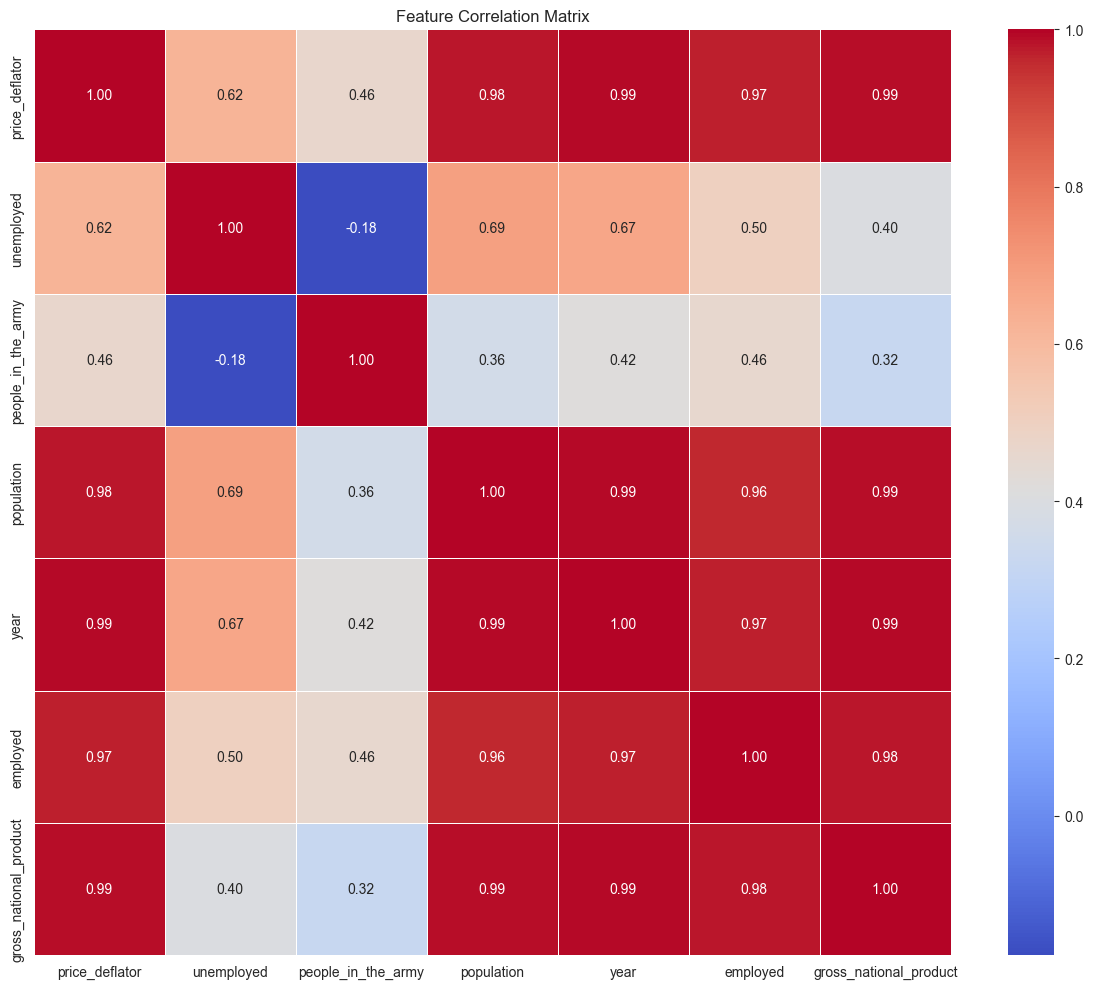

Feature correlation with target (gross_national_product):
gross_national_product    1.000000
year                      0.993731
population                0.989842
price_deflator            0.988213
employed                  0.977590
unemployed                0.401113
people_in_the_army        0.322293
Name: gross_national_product, dtype: float64
-------------------------------------------------------------------------------------------------------------------------------
=== Cross-Validation ===
Cross-Validation MSE: 12.2881 ± 8.9385
Cross-Validation MAE: 2.8054 ± 1.3960
Cross-Validation R²: 0.9963 ± 0.0035
-------------------------------------------------------------------------------------------------------------------------------
=== Basic Linear Regression ===
MSE test set: 5.7516
MSE train set: 5.2774

R² Score test: 0.9995
R² Score train: 0.9993

MAE test set: 1.7756
MAE train set: 1.7910

Coefficients: [ 1.76670922 -0.2095612  -0.08045585  4.53464212 16.34441155 -4.20547519]
Int

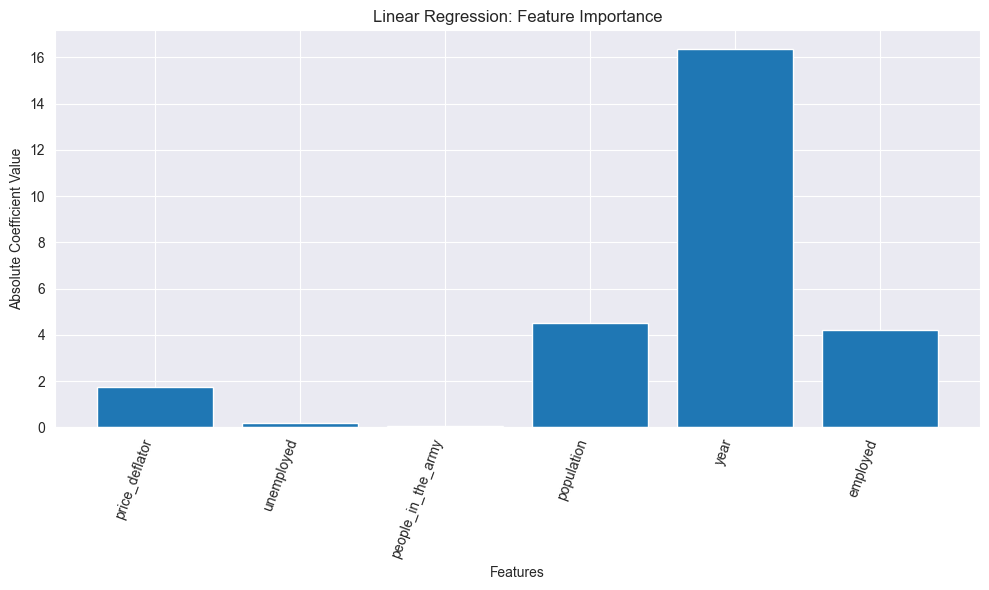

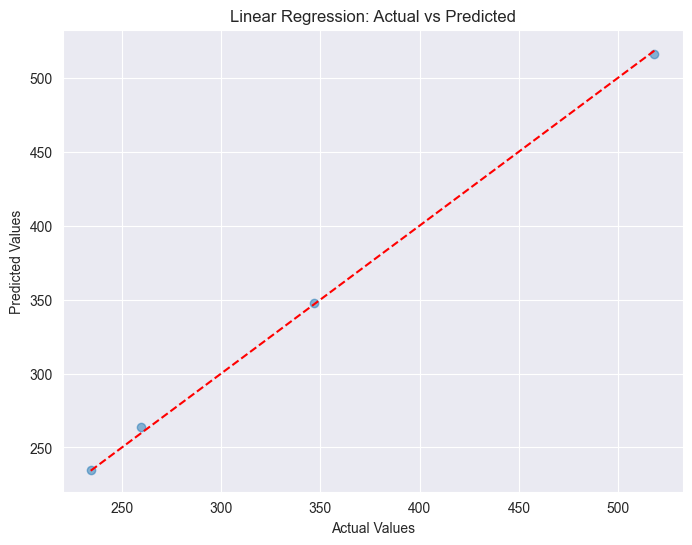

=== Scaled Linear Regression ===
MSE test set: 5.7516
MSE train set: 5.2774

R² Score test: 0.9995
R² Score train: 0.9993

MAE test set: 1.7756
MAE train set: 1.7910

Selected Features Coef_: ['price_deflator' 'unemployed' 'people_in_the_army' 'population' 'year'
 'employed']
-------------------------------------------------------------------------------------------------------------------------------


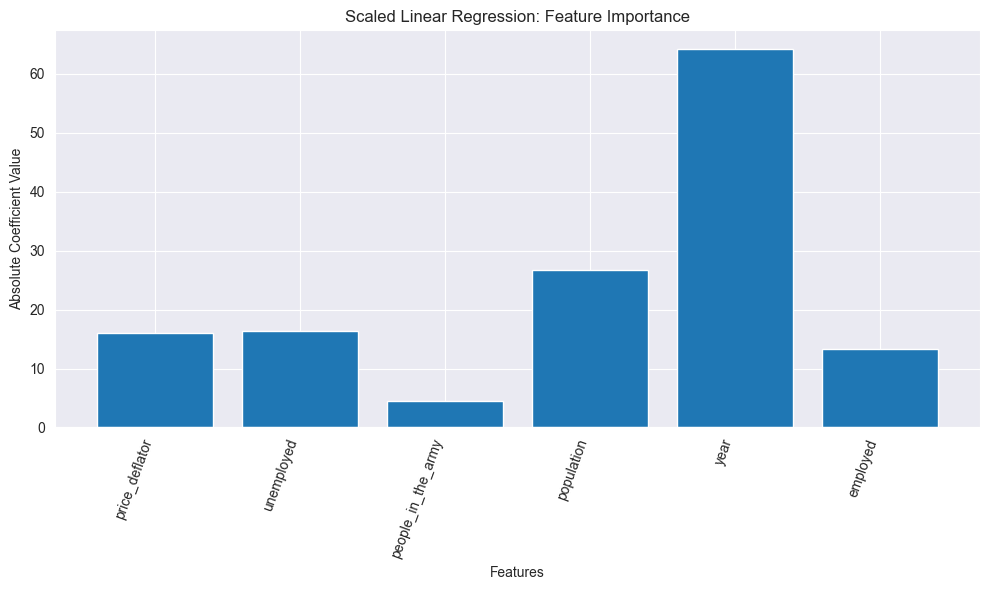

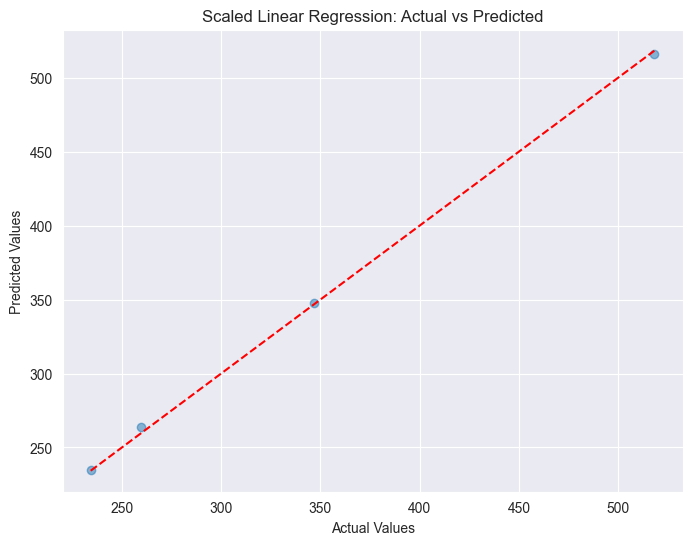

=== Feature Selection (SelectKBest) ===
MSE test set: 4.8402
MSE train set: 7.7821

R² Score test: 0.9996
R² Score train: 0.9989

MAE test set: 2.1971
MAE train set: 2.4510

Selected Features Selector : ['price_deflator' 'unemployed' 'population' 'year' 'employed']
-------------------------------------------------------------------------------------------------------------------------------


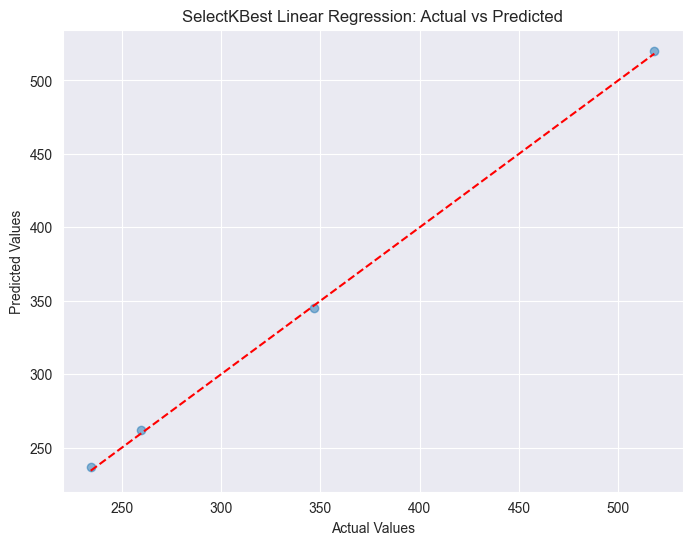

=== Feature Selection (RFE) ===
MSE test set: 4.8402
MSE train set: 7.7821

R² Score test: 0.9996
R² Score train: 0.9989

MAE test set: 2.1971
MAE train set: 2.4510

Selected Features Selector : ['price_deflator' 'unemployed' 'population' 'year' 'employed']
-------------------------------------------------------------------------------------------------------------------------------


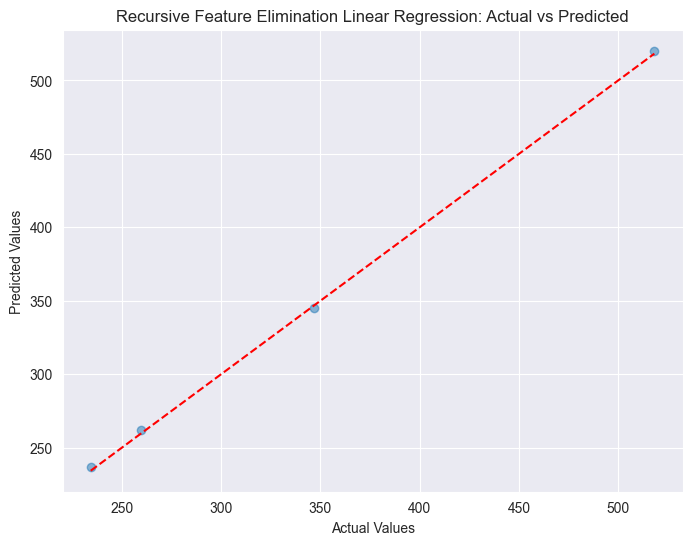

=== Polynomial Regression ===
MSE test set: 147.2193
MSE train set: 0.0000

R² Score test: 0.9881
R² Score train: 1.0000

MAE test set: 8.8550
MAE train set: 0.0000

Selected Features Coef_: ['price_deflator' 'unemployed' 'people_in_the_army' 'population' 'year'
 'employed' 'price_deflator^2' 'price_deflator unemployed'
 'price_deflator people_in_the_army' 'price_deflator population'
 'price_deflator year' 'price_deflator employed' 'unemployed^2'
 'unemployed people_in_the_army' 'unemployed population' 'unemployed year'
 'unemployed employed' 'people_in_the_army^2'
 'people_in_the_army population' 'people_in_the_army year'
 'people_in_the_army employed' 'population^2' 'population year'
 'population employed' 'year^2' 'year employed' 'employed^2']
-------------------------------------------------------------------------------------------------------------------------------


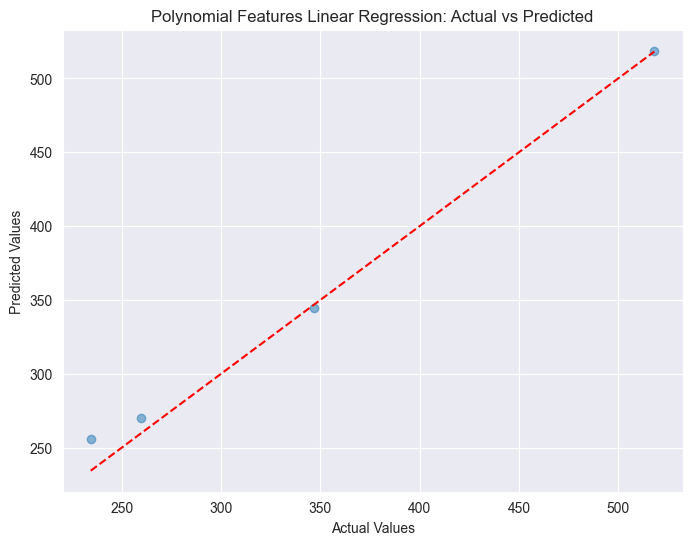

=== Ridge Regression ===
MSE test set:  7.4812
MSE train set: 5.8669

R² Score test: 0.9994
R² Score train:0.9992

MAE test set:  2.1267
MAE train set: 2.0243

Best alpha:    0.0100

Selected Features Coef_: ['price_deflator' 'unemployed' 'people_in_the_army' 'population' 'year'
 'employed']
-------------------------------------------------------------------------------------------------------------------------------


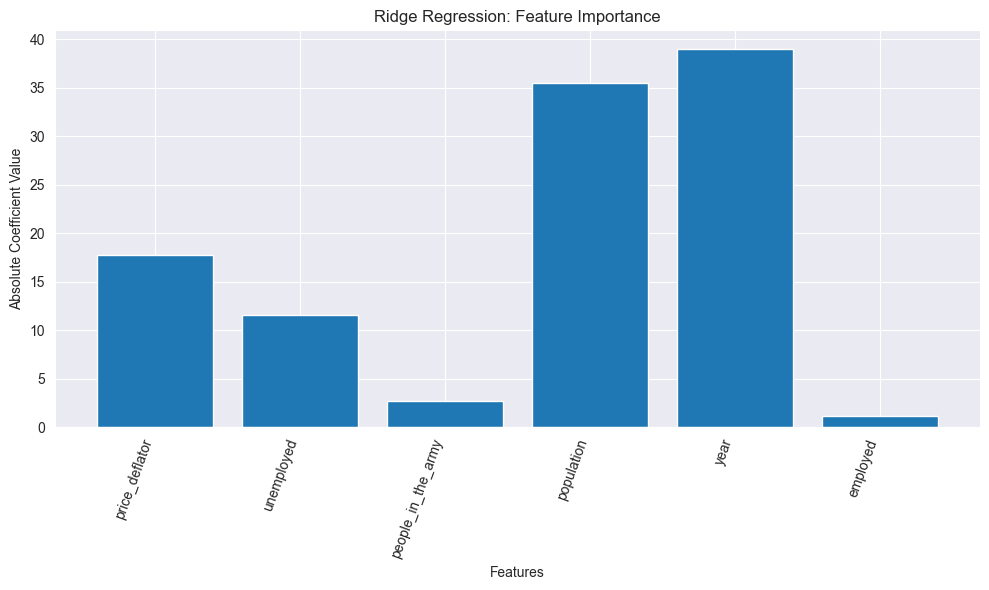

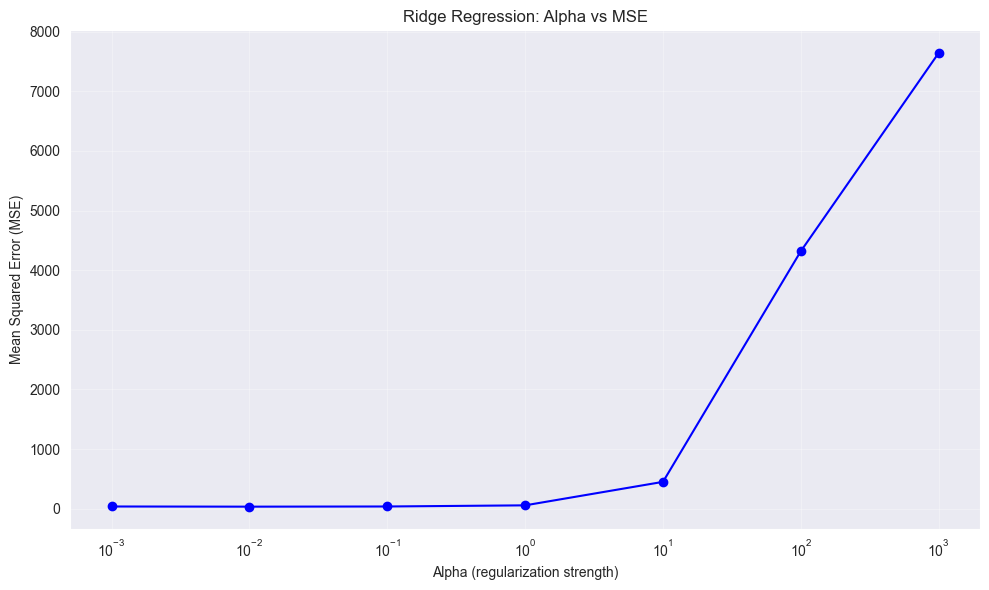

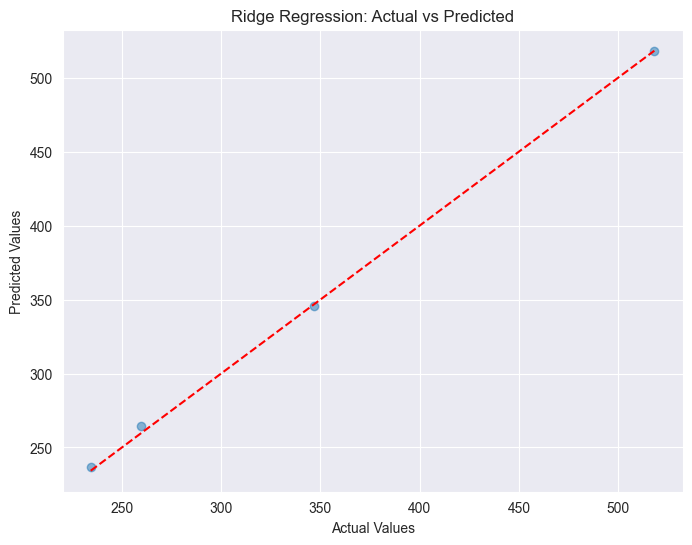

-------------------------------------------------------------------------------------------------------------------------------
=== Lasso Regression ===
MSE test set: 5.9234
MSE train set: 5.5672

R² Score test: 0.9995
R² Score train: 0.9992

MAE test set: 1.9411
MAE train set: 1.8877

Best alpha: 0.01

Selected features: ['price_deflator' 'unemployed' 'people_in_the_army' 'population' 'year'
 'employed']
-------------------------------------------------------------------------------------------------------------------------------


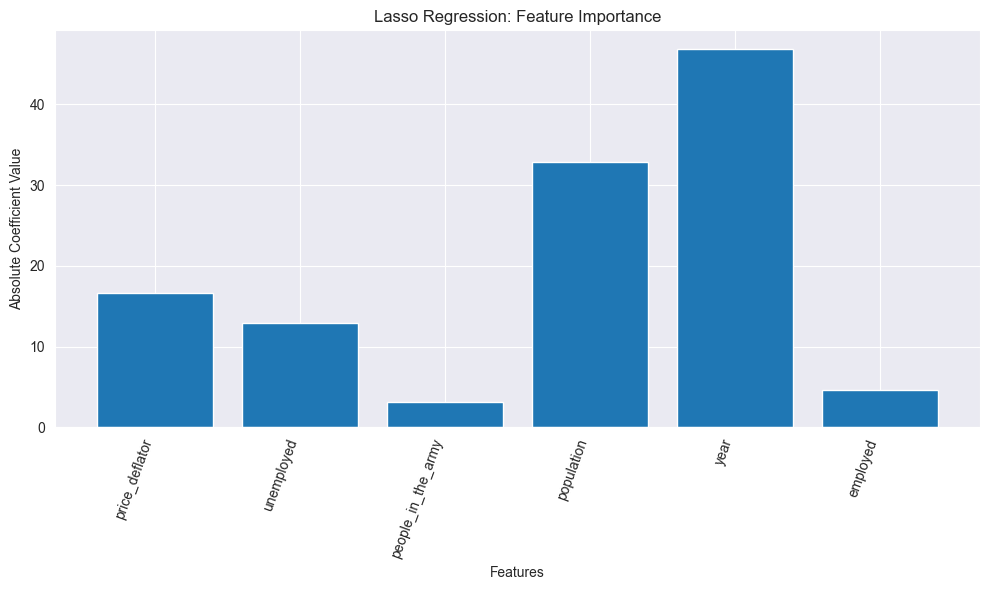

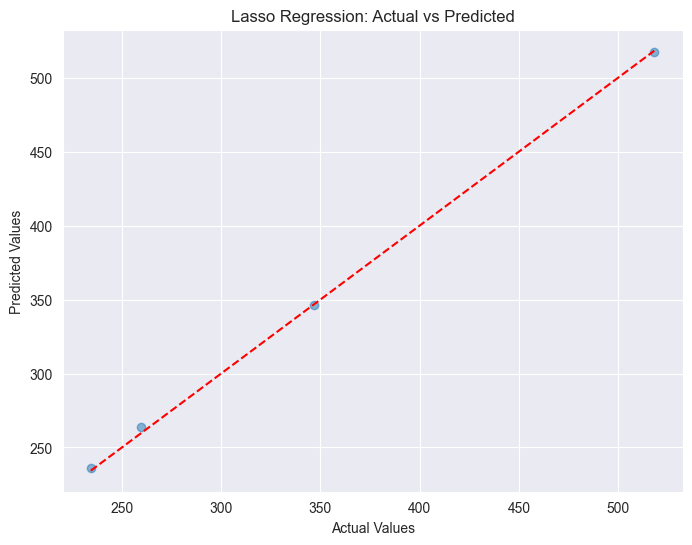

-------------------------------------------------------------------------------------------------------------------------------
=== Elastic Net Regression ===
MSE test set: 7.6257
MSE train set: 5.9152

R² Score test: 0.9994
R² Score train: 0.9992

MAE test set: 2.1437
MAE train set: 2.0435

Best parameters: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.1}

Selected Features Coef_: ['price_deflator' 'unemployed' 'people_in_the_army' 'population' 'year'
 'employed']
-------------------------------------------------------------------------------------------------------------------------------


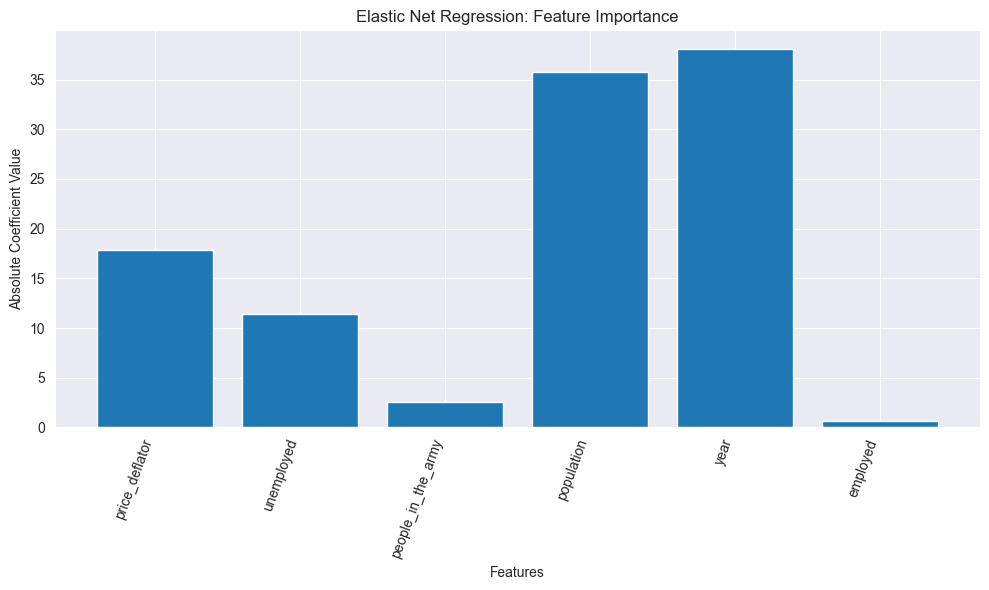

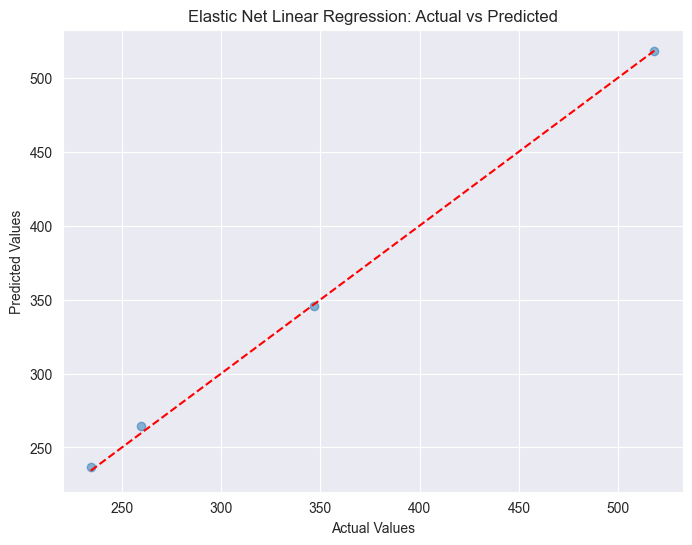

-------------------------------------------------------------------------------------------------------------------------------
=== Model Comparison ===
                                  MAE       MSE        R²
Polynomial Regression      147.219278  0.988094  8.855016
Elastic Net                  7.625711  0.999383  2.143744
Ridge Regression             7.481173  0.999395  2.126745
Lasso Regression             5.923433  0.999521  1.941062
Scaled Linear Regression     5.751614  0.999535  1.775616
Basic Linear Regression      5.751614  0.999535  1.775616
Feature Selection (KBest)    4.840247  0.999609  2.197092
Feature Selection (RFE)      4.840247  0.999609  2.197092
-------------------------------------------------------------------------------------------------------------------------------
Best model according to MAE: Polynomial Regression
Best model according to MSE: Polynomial Regression
Best model according to RMSE: Polynomial Regression
Best model according to R2_score: Polynomia

In [15]:
# Set random seed for reproducibility
np.random.seed(42)

# Training & Splitting
X = df.drop(columns=['gross_national_product'], axis=1)
y = df['gross_national_product']

print("Dataset shape:", X.shape)
print("Feature names:", X.columns)
print() 

# For short dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X Train shape:", X_train.shape)
print("Y Train shape:", y_train.shape)
print("X Test shape:",  X_test.shape)
print("Y Test shape:",  y_test.shape)
print("-" * 127) 

# Basic Linear Regression model
def basic_linear_regression():
    print("=== Basic Linear Regression ===")
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n") 
    print("Coefficients:", model.coef_)
    print("Intercept:", model.intercept_)
    
    # Check which features were selected (non-zero coefficients)
    lr_coef = model.coef_
    selected_features = np.array(X_train.columns)[lr_coef != 0]
    print(f"\nSelected features: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Linear Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Linear Regression: Actual vs Predicted')
    plt.show()

    return model, mse_test, r2_test, mae_test

# Feature Scaling
def scaled_linear_regression():
    print("=== Scaled Linear Regression ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    # Check which features were selected (non-zero coefficients)
    scaled_lr_coef = pipeline.named_steps['regression'].coef_
    selected_features = np.array(X_train.columns)[scaled_lr_coef != 0]
    print(f"Selected Features Coef_: {selected_features}") 
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(scaled_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Scaled Linear Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Scaled Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Feature Selection with SelectKBest
def feature_selection_kbest():
    print("=== Feature Selection (SelectKBest) ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(f_regression, k=5)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train) 

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    selected_features = np.array(X_train.columns)[pipeline.named_steps['selector'].get_support()]
    print(f"Selected Features Selector : {selected_features}")
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('SelectKBest Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Feature Selection with Recursive Feature Elimination (RFE)
def feature_selection_rfe():
    print("=== Feature Selection (RFE) ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', RFE(LinearRegression(), n_features_to_select=5)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    selected_features = np.array(X_train.columns)[pipeline.named_steps['selector'].get_support()]
    print(f"Selected Features Selector : {selected_features}") 
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Recursive Feature Elimination Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Polynomial Features
def polynomial_regression():
    print("=== Polynomial Regression ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}") 

    # Get the polynomial feature names
    poly_features = pipeline.named_steps['poly'].get_feature_names_out(X_train.columns)
    
    # Get coefficients from the regression step
    poly_coef = pipeline.named_steps['regression'].coef_
    
    # Find selected features (non-zero coefficients)
    selected_features = poly_features[poly_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Polynomial Features Linear Regression: Actual vs Predicted')
    plt.show()  
    
    return pipeline, mse_test, r2_test, mae_test

# Regularized Linear Regression - Ridge
def ridge_regression():
    print("=== Ridge Regression ===")
    param_grid = {'ridge__alpha': np.logspace(-3, 3, 7)}
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(random_state=42))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)
    
    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set:  {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train:{r2_train:.4f}\n")
    print(f"MAE test set:  {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    print(f"Best alpha:    {grid_search.best_params_['ridge__alpha']:.4f}")
  
    # Check which features were selected (non-zero coefficients)
    ridge_lr_coef = grid_search.best_estimator_['ridge'].coef_
    selected_features = np.array(X_train.columns)[ridge_lr_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(ridge_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Ridge Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize alpha vs MSE
    plt.figure(figsize=(10, 6))
    results = pd.DataFrame(grid_search.cv_results_)
    alphas = np.array(param_grid['ridge__alpha'])
    scores = -results['mean_test_score']
    plt.semilogx(alphas, scores, 'b-o')
    plt.xlabel('Alpha (regularization strength)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Ridge Regression: Alpha vs MSE')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Ridge Regression: Actual vs Predicted')
    plt.show() 
    print("-" * 127) 
    
    return best_model, mse_test, r2_test, mae_test

# Regularized Linear Regression - Lasso
def lasso_regression():
    print("=== Lasso Regression ===")
    param_grid = {'lasso__alpha': np.logspace(-3, 1, 5)}
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', Lasso(random_state=42, max_iter=10000))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")   
    print(f"Best alpha: {grid_search.best_params_['lasso__alpha']}") 
    
    # Check which features were selected (non-zero coefficients)
    lasso_coef = best_model.named_steps['lasso'].coef_
    selected_features = np.array(X_train.columns)[lasso_coef != 0]
    print(f"\nSelected features: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(lasso_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Lasso Regression: Feature Importance')
    plt.tight_layout()
    plt.show()

    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Lasso Regression: Actual vs Predicted')
    plt.show() 
    print("-" * 127)
    
    return best_model, mse_test, r2_test, mae_test

# Elastic Net
def elastic_net_regression():
    print("=== Elastic Net Regression ===")
    param_grid = {
        'elasticnet__alpha': np.logspace(-3, 1, 5),
        'elasticnet__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99]
    }
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('elasticnet', ElasticNet(random_state=42, max_iter=10000))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train) 

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")    
    print(f"Best parameters: {grid_search.best_params_}")

    # Check which features were selected (non-zero coefficients)
    elastic_lr_coef = grid_search.best_estimator_['elasticnet'].coef_
    selected_features = np.array(X_train.columns)[elastic_lr_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(elastic_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Elastic Net Regression: Feature Importance')
    plt.tight_layout()
    plt.show()  
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Elastic Net Linear Regression: Actual vs Predicted')
    plt.show() 
    print("-" * 127) 
    
    return best_model, mse_test, r2_test, mae_test

# Cross-validation with MAE, MSE, and R² scores
def cross_validation_example():
    print("-" * 127)
    print("=== Cross-Validation ===")
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('regression', LinearRegression())
    ])
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Calculate different metrics
    mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    mae_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    rmse_scores = np.sqrt(mse_scores)
    
    print(f"Cross-Validation MSE: {mse_scores.mean():.4f} ± {mse_scores.std():.4f}")
    print(f"Cross-Validation MAE: {mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
    print(f"Cross-Validation R²: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")
    print("-" * 127) 
    
    return mse_scores, mae_scores, r2_scores, rmse_scores
        
# Compare all models
def compare_models():
    models = {
        'Basic Linear Regression': basic_linear_regression(),
        'Scaled Linear Regression': scaled_linear_regression(),
        'Feature Selection (KBest)': feature_selection_kbest(),
        'Feature Selection (RFE)': feature_selection_rfe(),
        'Polynomial Regression': polynomial_regression(),
        'Ridge Regression': ridge_regression(),
        'Lasso Regression': lasso_regression(),
        'Elastic Net': elastic_net_regression()
    }

    # Extract MSE and R² scores
    results = {name: {'MAE': mae_scores, 'MSE': mse_scores, 'R²': r2_scores} 
           for name, (_, mae_scores, mse_scores, r2_scores) in models.items()} 

    results_df = pd.DataFrame(results).T
    
    # Sort by MSE (lower is better)
    results_df = results_df.sort_values('MSE')
    
    print("=== Model Comparison ===")
    print(results_df)
    print("-" * 127) 
    
    return results_df 

    # Plot comparison
    plt.figure(figsize=(12, 15))  # Increase height for 3 subplots

    plt.subplot(3, 1, 1)  # This now works with 3 rows
    plt.bar(results_df.index, results_df['MAE'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Model Comparison - MAE (lower is better)')
    
    plt.subplot(3, 1, 2)  # Change to 3 rows
    plt.bar(results_df.index, results_df['MSE'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Model Comparison - MSE (lower is better)')
    
    plt.subplot(3, 1, 3)  # Change to 3 rows
    plt.bar(results_df.index, results_df['R²'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('R² Score (higher is better)')
    plt.title('Model Comparison - R² (higher is better)')

    plt.tight_layout()
    plt.show()
    
# Feature Correlation Analysis
def feature_correlation_analysis():
    print("=== Feature Correlation Analysis ===")
    X_df = pd.DataFrame(df, columns=X_train.columns)  # Always change the df value based on the df's name you're using
    X_df['gross_national_product'] = y_train  # Always change the X_df value 
    
    corr = X_df.corr()
    
    # Plot correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Sort features by correlation with target
    target_corr = corr['gross_national_product'].sort_values(ascending=False) # Always change the target_coor value 
    print("Feature correlation with target (gross_national_product):")  # Always change the variable value 
    print(target_corr)
    
    return corr

# Main execution
if __name__ == "__main__":
    print("=== Linear Regression Tuning Examples ===")
    feature_correlation_analysis()
    cross_validation_example()
    results = compare_models()
    
    print(f"Best model according to MAE: {results.index[0]}")
    print(f"Best model according to MSE: {results.index[0]}")
    print(f"Best model according to RMSE: {results.index[0]}")
    print(f"Best model according to R2_score: {results.index[0]}")
    print("-" * 127) 

In [14]:
df.head(2)

,price_deflator,gross_national_product,unemployed,people_in_the_army,population,year,employed
0,83.0,234.29,235.6,159.0,107.61,1947,60.32
1,88.5,259.43,232.5,145.6,108.63,1948,61.12


## LinearRegression

Dataset shape: (16, 6)
Feature names: Index(['price_deflator', 'gross_national_product', 'unemployed', 'people_in_the_army', 'population', 'employed'], dtype='object')

X Train shape: (12, 6)
Y Train shape: (12,)
X Test shape: (4, 6)
Y Test shape: (4,)
-------------------------------------------------------------------------------------------------------------------------------
=== Linear Regression Tuning Examples ===
=== Feature Correlation Analysis ===


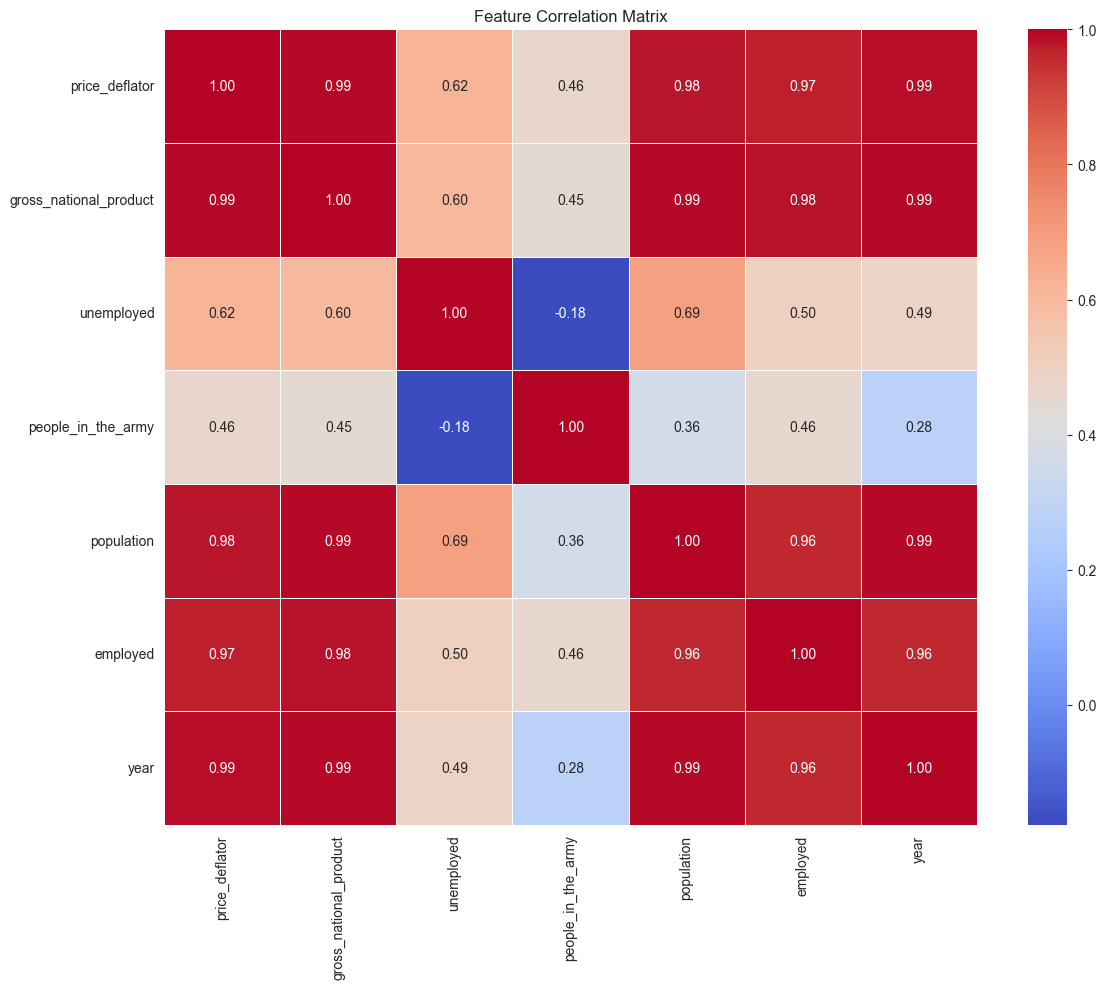

Feature correlation with target (year):
year                      1.000000
gross_national_product    0.993731
population                0.993569
price_deflator            0.989352
employed                  0.961305
unemployed                0.487766
people_in_the_army        0.275791
Name: year, dtype: float64
-------------------------------------------------------------------------------------------------------------------------------
=== Cross-Validation ===
Cross-Validation MSE: 0.0279 ± 0.0154
Cross-Validation MAE: 0.1336 ± 0.0456
Cross-Validation R²: 0.9974 ± 0.0030
-------------------------------------------------------------------------------------------------------------------------------
=== Basic Linear Regression ===
MSE test set: 0.0324
MSE train set: 0.0079

R² Score test: 0.9989
R² Score train: 0.9995

MAE test set: 0.1517
MAE train set: 0.0737

Coefficients: [-0.01678103  0.02451104  0.01017304  0.00469422  0.04542432  0.4211886 ]
Intercept: 1909.4082178909619

Selected 

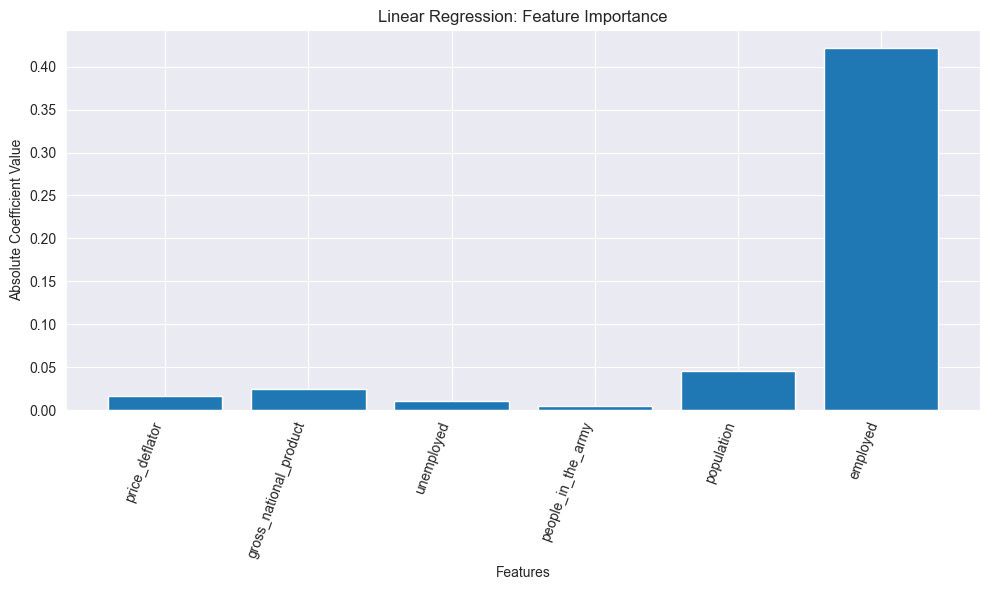

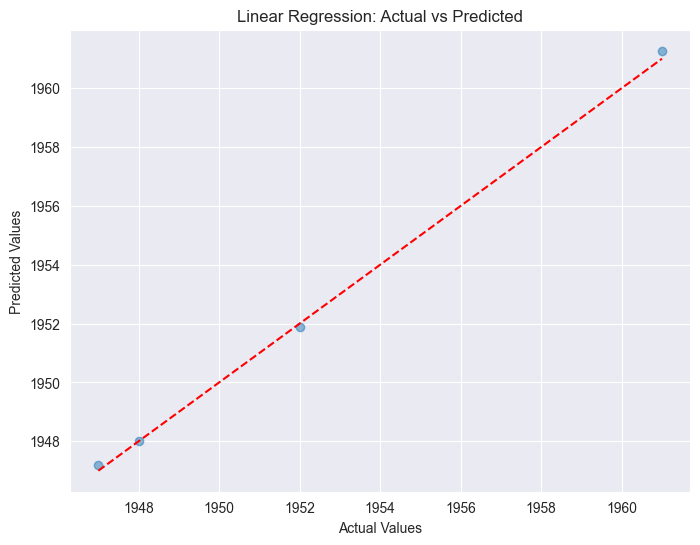

=== Scaled Linear Regression ===
MSE test set: 0.0324
MSE train set: 0.0079

R² Score test: 0.9989
R² Score train: 0.9995

MAE test set: 0.1517
MAE train set: 0.0737

Selected Features Coef_: ['price_deflator' 'gross_national_product' 'unemployed'
 'people_in_the_army' 'population' 'employed']
-------------------------------------------------------------------------------------------------------------------------------


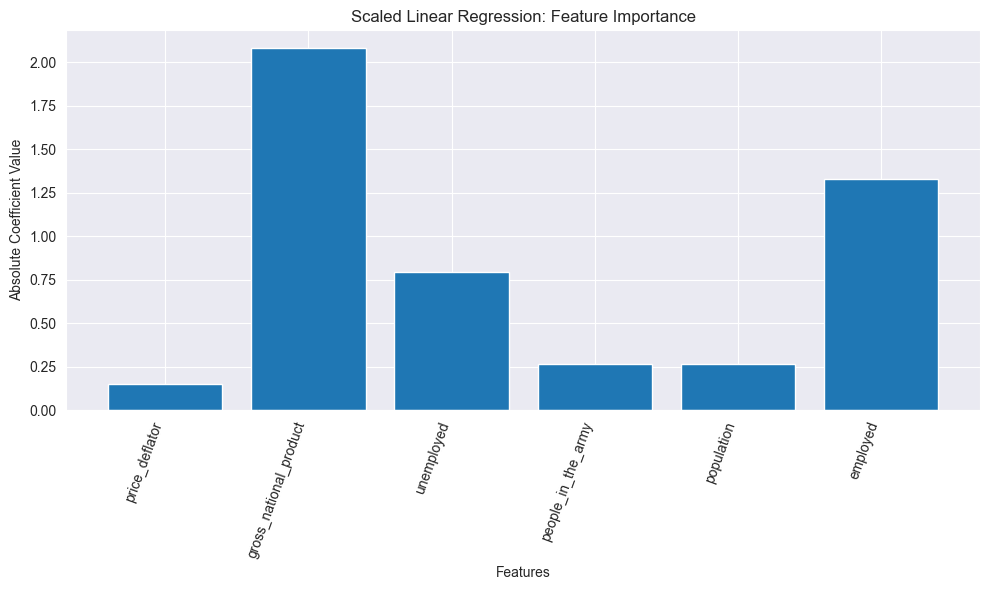

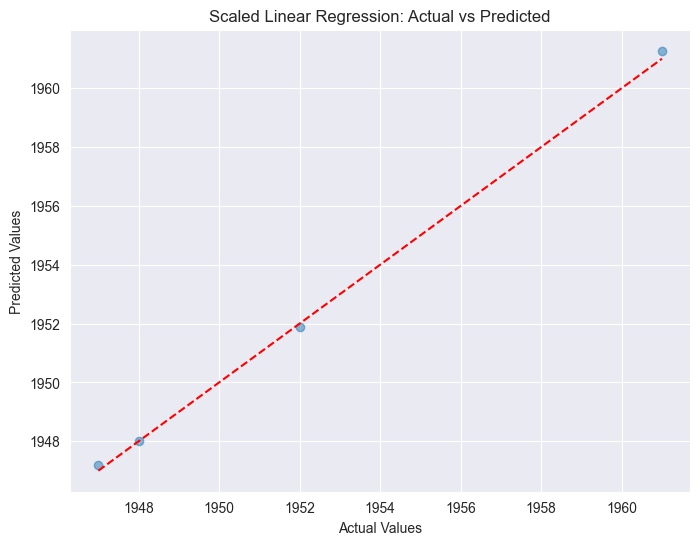

=== Feature Selection (SelectKBest) ===
MSE test set: 0.1429
MSE train set: 0.0294

R² Score test: 0.9953
R² Score train: 0.9981

MAE test set: 0.3221
MAE train set: 0.1326

Selected Features Selector : ['price_deflator' 'gross_national_product' 'unemployed' 'population'
 'employed']
-------------------------------------------------------------------------------------------------------------------------------


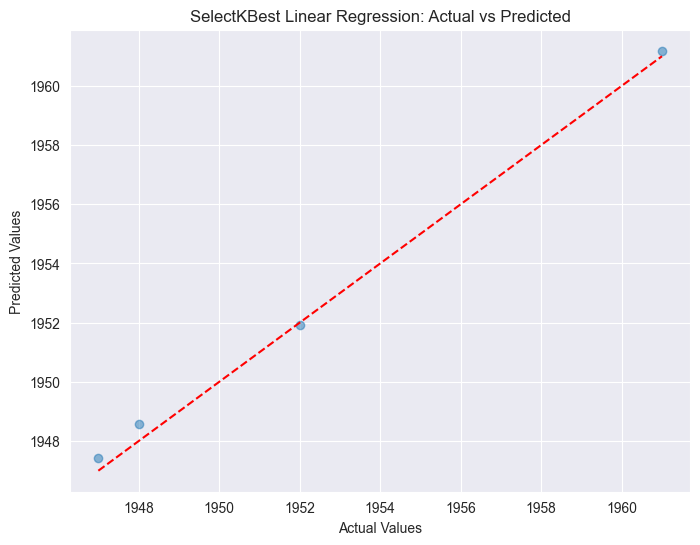

=== Feature Selection (RFE) ===
MSE test set: 0.0341
MSE train set: 0.0081

R² Score test: 0.9989
R² Score train: 0.9995

MAE test set: 0.1645
MAE train set: 0.0763

Selected Features Selector : ['gross_national_product' 'unemployed' 'people_in_the_army' 'population'
 'employed']
-------------------------------------------------------------------------------------------------------------------------------


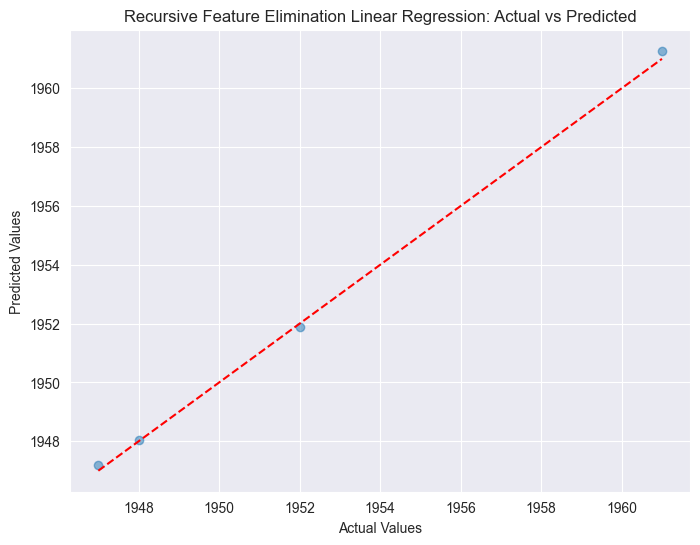

=== Polynomial Regression ===
MSE test set: 0.0174
MSE train set: 0.0000

R² Score test: 0.9994
R² Score train: 1.0000

MAE test set: 0.0941
MAE train set: 0.0000

Selected Features Coef_: ['price_deflator' 'gross_national_product' 'unemployed'
 'people_in_the_army' 'population' 'employed' 'price_deflator^2'
 'price_deflator gross_national_product' 'price_deflator unemployed'
 'price_deflator people_in_the_army' 'price_deflator population'
 'price_deflator employed' 'gross_national_product^2'
 'gross_national_product unemployed'
 'gross_national_product people_in_the_army'
 'gross_national_product population' 'gross_national_product employed'
 'unemployed^2' 'unemployed people_in_the_army' 'unemployed population'
 'unemployed employed' 'people_in_the_army^2'
 'people_in_the_army population' 'people_in_the_army employed'
 'population^2' 'population employed' 'employed^2']
--------------------------------------------------------------------------------------------------------------------

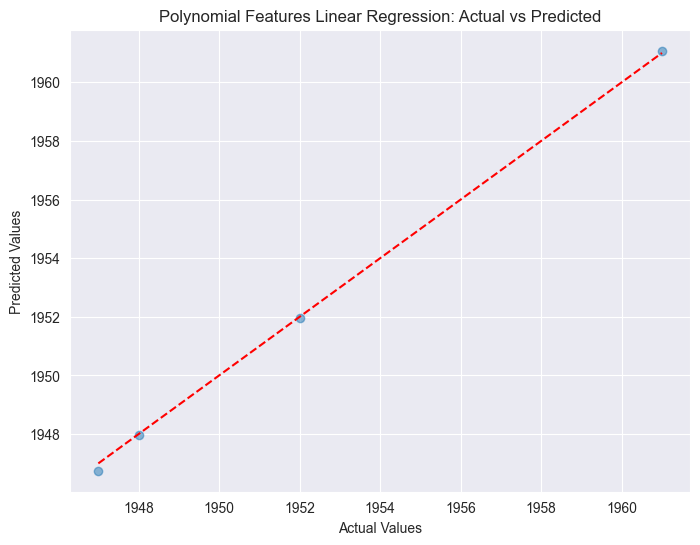

=== Ridge Regression ===
MSE test set:  0.0475
MSE train set: 0.0115

R² Score test: 0.9984
R² Score train:0.9993

MAE test set:  0.2020
MAE train set: 0.0863

Best alpha:    0.1000

Selected Features Coef_: ['price_deflator' 'gross_national_product' 'unemployed'
 'people_in_the_army' 'population' 'employed']
-------------------------------------------------------------------------------------------------------------------------------


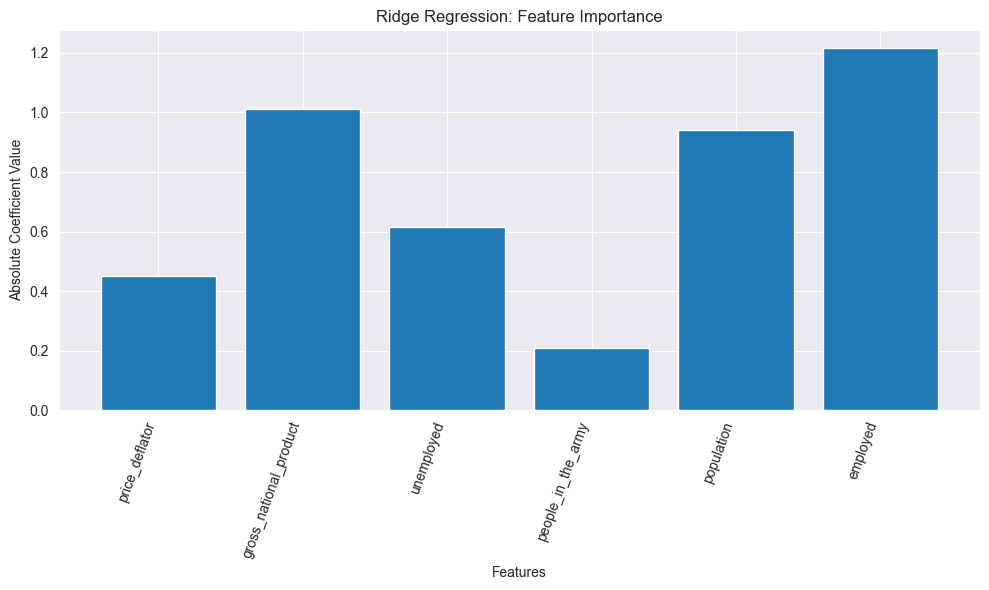

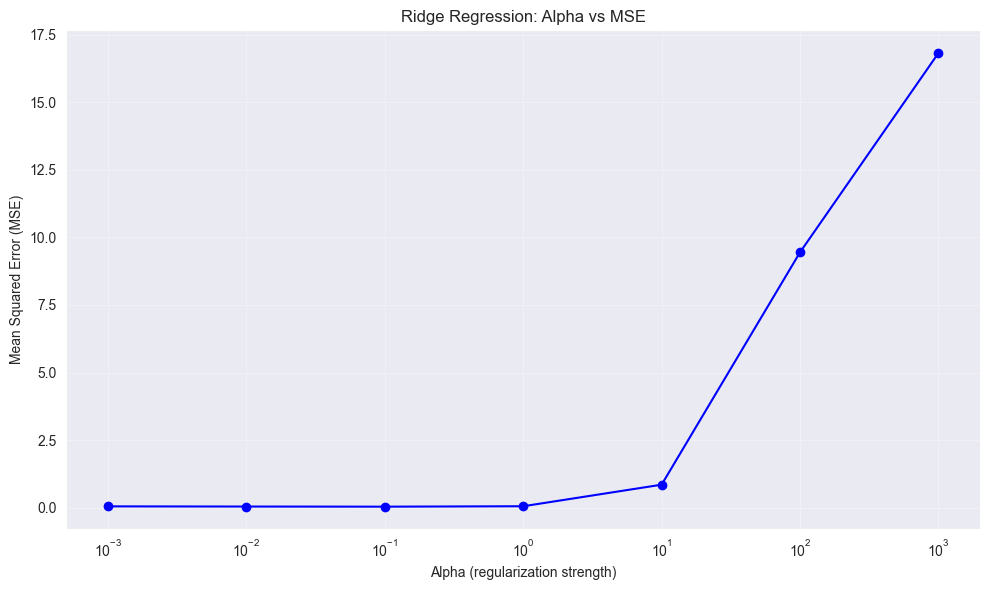

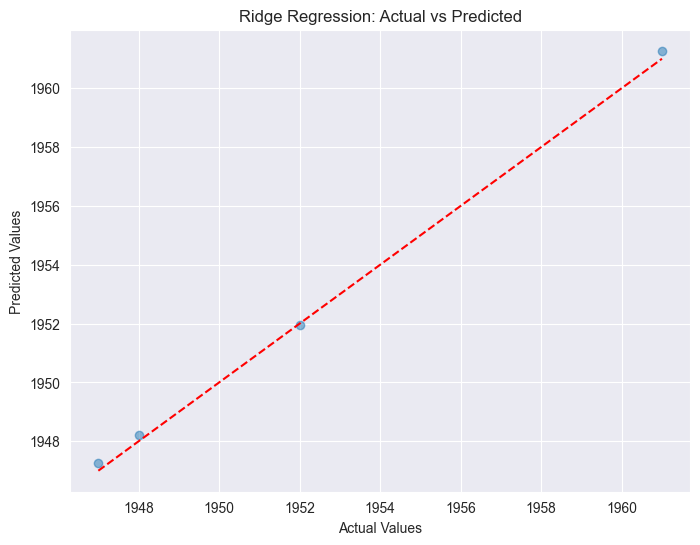

-------------------------------------------------------------------------------------------------------------------------------
=== Lasso Regression ===
MSE test set: 0.0328
MSE train set: 0.0081

R² Score test: 0.9989
R² Score train: 0.9995

MAE test set: 0.1625
MAE train set: 0.0761

Best alpha: 0.001

Selected features: ['gross_national_product' 'unemployed' 'people_in_the_army' 'population'
 'employed']
-------------------------------------------------------------------------------------------------------------------------------


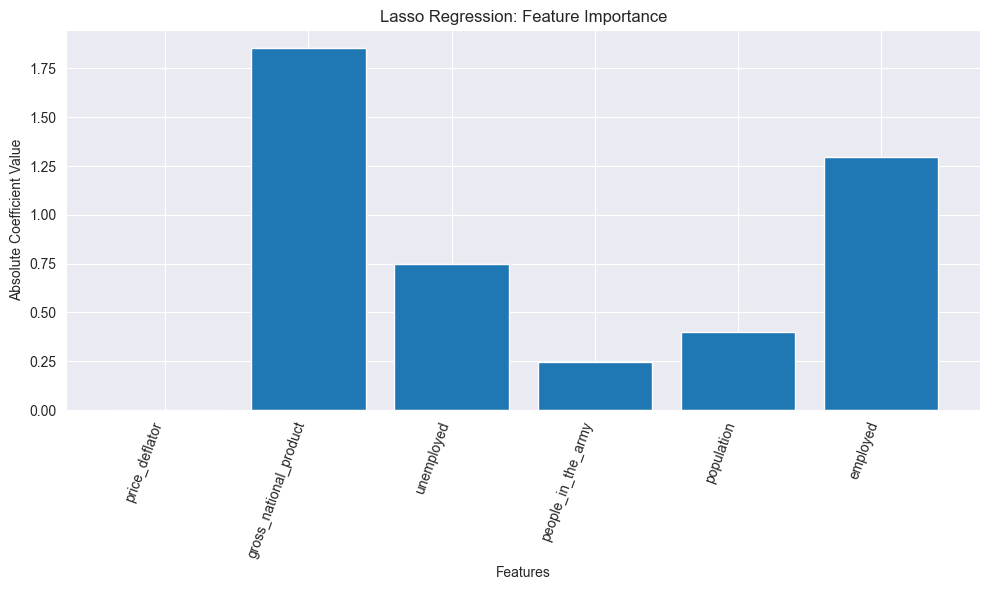

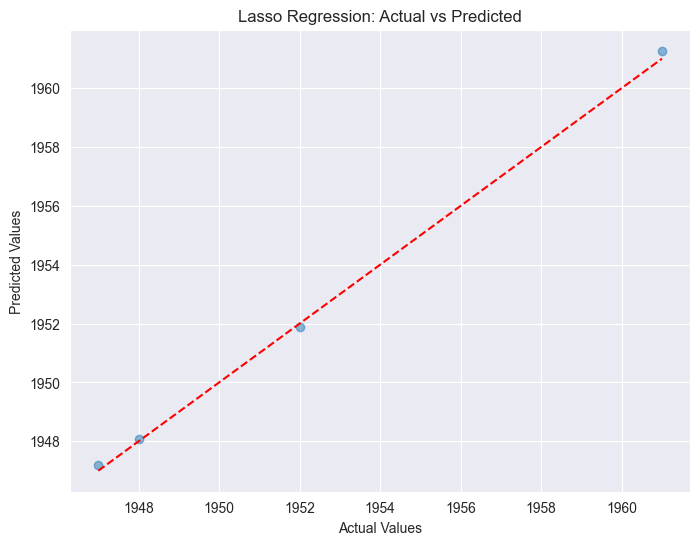

-------------------------------------------------------------------------------------------------------------------------------
=== Elastic Net Regression ===
MSE test set: 0.0490
MSE train set: 0.0118

R² Score test: 0.9984
R² Score train: 0.9992

MAE test set: 0.2042
MAE train set: 0.0865

Best parameters: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.1}

Selected Features Coef_: ['price_deflator' 'gross_national_product' 'unemployed'
 'people_in_the_army' 'population' 'employed']
-------------------------------------------------------------------------------------------------------------------------------


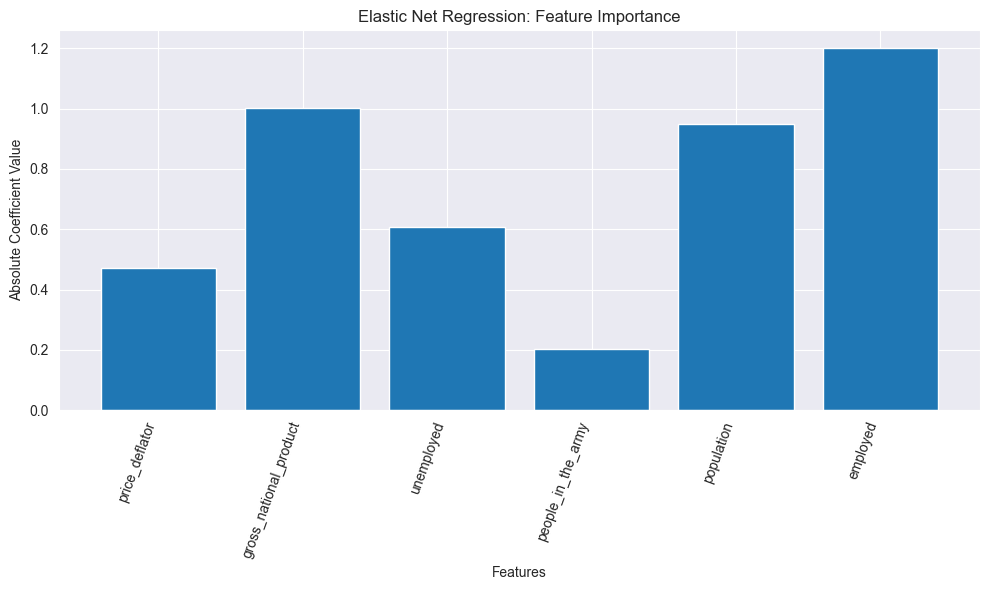

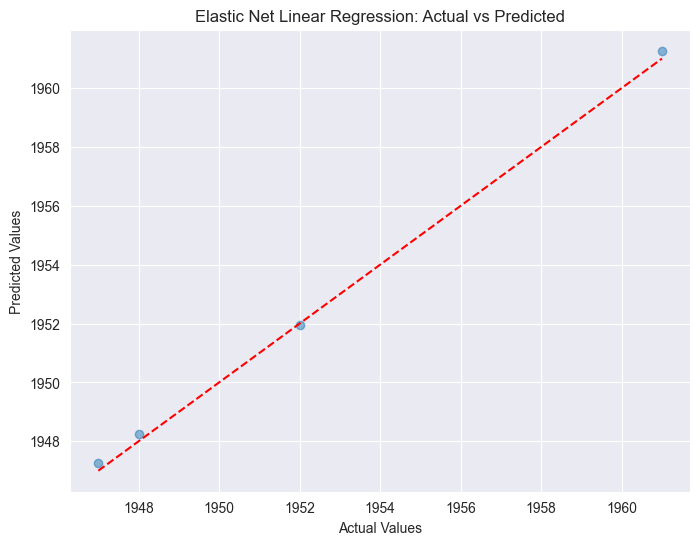

-------------------------------------------------------------------------------------------------------------------------------
=== Model Comparison ===
                                MAE       MSE        R²
Feature Selection (KBest)  0.142891  0.995315  0.322141
Elastic Net                0.048991  0.998394  0.204238
Ridge Regression           0.047495  0.998443  0.201972
Feature Selection (RFE)    0.034061  0.998883  0.164503
Lasso Regression           0.032825  0.998924  0.162466
Basic Linear Regression    0.032394  0.998938  0.151669
Scaled Linear Regression   0.032394  0.998938  0.151669
Polynomial Regression      0.017416  0.999429  0.094140
-------------------------------------------------------------------------------------------------------------------------------
Best model according to MAE: Feature Selection (KBest)
Best model according to MSE: Feature Selection (KBest)
Best model according to RMSE: Feature Selection (KBest)
Best model according to R2_score: Feature Selecti

In [16]:
# Set random seed for reproducibility
np.random.seed(42)

# Training & Splitting
X = df.drop(columns=['year'], axis=1)
y = df['year']

print("Dataset shape:", X.shape)
print("Feature names:", X.columns)
print() 

# For short dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X Train shape:", X_train.shape)
print("Y Train shape:", y_train.shape)
print("X Test shape:",  X_test.shape)
print("Y Test shape:",  y_test.shape)
print("-" * 127) 

# Basic Linear Regression model
def basic_linear_regression():
    print("=== Basic Linear Regression ===")
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n") 
    print("Coefficients:", model.coef_)
    print("Intercept:", model.intercept_)
    
    # Check which features were selected (non-zero coefficients)
    lr_coef = model.coef_
    selected_features = np.array(X_train.columns)[lr_coef != 0]
    print(f"\nSelected features: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Linear Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Linear Regression: Actual vs Predicted')
    plt.show()

    return model, mse_test, r2_test, mae_test

# Feature Scaling
def scaled_linear_regression():
    print("=== Scaled Linear Regression ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    # Check which features were selected (non-zero coefficients)
    scaled_lr_coef = pipeline.named_steps['regression'].coef_
    selected_features = np.array(X_train.columns)[scaled_lr_coef != 0]
    print(f"Selected Features Coef_: {selected_features}") 
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(scaled_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Scaled Linear Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Scaled Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Feature Selection with SelectKBest
def feature_selection_kbest():
    print("=== Feature Selection (SelectKBest) ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(f_regression, k=5)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train) 

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    selected_features = np.array(X_train.columns)[pipeline.named_steps['selector'].get_support()]
    print(f"Selected Features Selector : {selected_features}")
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('SelectKBest Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Feature Selection with Recursive Feature Elimination (RFE)
def feature_selection_rfe():
    print("=== Feature Selection (RFE) ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', RFE(LinearRegression(), n_features_to_select=5)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    selected_features = np.array(X_train.columns)[pipeline.named_steps['selector'].get_support()]
    print(f"Selected Features Selector : {selected_features}") 
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Recursive Feature Elimination Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Polynomial Features
def polynomial_regression():
    print("=== Polynomial Regression ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}") 

    # Get the polynomial feature names
    poly_features = pipeline.named_steps['poly'].get_feature_names_out(X_train.columns)
    
    # Get coefficients from the regression step
    poly_coef = pipeline.named_steps['regression'].coef_
    
    # Find selected features (non-zero coefficients)
    selected_features = poly_features[poly_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Polynomial Features Linear Regression: Actual vs Predicted')
    plt.show()  
    
    return pipeline, mse_test, r2_test, mae_test

# Regularized Linear Regression - Ridge
def ridge_regression():
    print("=== Ridge Regression ===")
    param_grid = {'ridge__alpha': np.logspace(-3, 3, 7)}
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(random_state=42))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)
    
    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set:  {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train:{r2_train:.4f}\n")
    print(f"MAE test set:  {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    print(f"Best alpha:    {grid_search.best_params_['ridge__alpha']:.4f}")
  
    # Check which features were selected (non-zero coefficients)
    ridge_lr_coef = grid_search.best_estimator_['ridge'].coef_
    selected_features = np.array(X_train.columns)[ridge_lr_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(ridge_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Ridge Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize alpha vs MSE
    plt.figure(figsize=(10, 6))
    results = pd.DataFrame(grid_search.cv_results_)
    alphas = np.array(param_grid['ridge__alpha'])
    scores = -results['mean_test_score']
    plt.semilogx(alphas, scores, 'b-o')
    plt.xlabel('Alpha (regularization strength)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Ridge Regression: Alpha vs MSE')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Ridge Regression: Actual vs Predicted')
    plt.show() 
    print("-" * 127) 
    
    return best_model, mse_test, r2_test, mae_test

# Regularized Linear Regression - Lasso
def lasso_regression():
    print("=== Lasso Regression ===")
    param_grid = {'lasso__alpha': np.logspace(-3, 1, 5)}
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', Lasso(random_state=42, max_iter=10000))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")   
    print(f"Best alpha: {grid_search.best_params_['lasso__alpha']}") 
    
    # Check which features were selected (non-zero coefficients)
    lasso_coef = best_model.named_steps['lasso'].coef_
    selected_features = np.array(X_train.columns)[lasso_coef != 0]
    print(f"\nSelected features: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(lasso_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Lasso Regression: Feature Importance')
    plt.tight_layout()
    plt.show()

    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Lasso Regression: Actual vs Predicted')
    plt.show() 
    print("-" * 127)
    
    return best_model, mse_test, r2_test, mae_test

# Elastic Net
def elastic_net_regression():
    print("=== Elastic Net Regression ===")
    param_grid = {
        'elasticnet__alpha': np.logspace(-3, 1, 5),
        'elasticnet__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99]
    }
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('elasticnet', ElasticNet(random_state=42, max_iter=10000))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train) 

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")    
    print(f"Best parameters: {grid_search.best_params_}")

    # Check which features were selected (non-zero coefficients)
    elastic_lr_coef = grid_search.best_estimator_['elasticnet'].coef_
    selected_features = np.array(X_train.columns)[elastic_lr_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(elastic_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Elastic Net Regression: Feature Importance')
    plt.tight_layout()
    plt.show()  
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Elastic Net Linear Regression: Actual vs Predicted')
    plt.show() 
    print("-" * 127) 
    
    return best_model, mse_test, r2_test, mae_test

# Cross-validation with MAE, MSE, and R² scores
def cross_validation_example():
    print("-" * 127)
    print("=== Cross-Validation ===")
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('regression', LinearRegression())
    ])
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Calculate different metrics
    mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    mae_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    rmse_scores = np.sqrt(mse_scores)
    
    print(f"Cross-Validation MSE: {mse_scores.mean():.4f} ± {mse_scores.std():.4f}")
    print(f"Cross-Validation MAE: {mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
    print(f"Cross-Validation R²: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")
    print("-" * 127) 
    
    return mse_scores, mae_scores, r2_scores, rmse_scores
        
# Compare all models
def compare_models():
    models = {
        'Basic Linear Regression': basic_linear_regression(),
        'Scaled Linear Regression': scaled_linear_regression(),
        'Feature Selection (KBest)': feature_selection_kbest(),
        'Feature Selection (RFE)': feature_selection_rfe(),
        'Polynomial Regression': polynomial_regression(),
        'Ridge Regression': ridge_regression(),
        'Lasso Regression': lasso_regression(),
        'Elastic Net': elastic_net_regression()
    }

    # Extract MSE and R² scores
    results = {name: {'MAE': mae_scores, 'MSE': mse_scores, 'R²': r2_scores} 
           for name, (_, mae_scores, mse_scores, r2_scores) in models.items()} 

    results_df = pd.DataFrame(results).T
    
    # Sort by MSE (lower is better)
    results_df = results_df.sort_values('MSE')
    
    print("=== Model Comparison ===")
    print(results_df)
    print("-" * 127) 
    
    return results_df 

    # Plot comparison
    plt.figure(figsize=(12, 15))  # Increase height for 3 subplots

    plt.subplot(3, 1, 1)  # This now works with 3 rows
    plt.bar(results_df.index, results_df['MAE'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Model Comparison - MAE (lower is better)')
    
    plt.subplot(3, 1, 2)  # Change to 3 rows
    plt.bar(results_df.index, results_df['MSE'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Model Comparison - MSE (lower is better)')
    
    plt.subplot(3, 1, 3)  # Change to 3 rows
    plt.bar(results_df.index, results_df['R²'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('R² Score (higher is better)')
    plt.title('Model Comparison - R² (higher is better)')

    plt.tight_layout()
    plt.show()
    
# Feature Correlation Analysis
def feature_correlation_analysis():
    print("=== Feature Correlation Analysis ===")
    X_df = pd.DataFrame(df, columns=X_train.columns)  # Always change the df value based on the df's name you're using
    X_df['year'] = y_train  # Always change the X_df value 
    
    corr = X_df.corr()
    
    # Plot correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Sort features by correlation with target
    target_corr = corr['year'].sort_values(ascending=False) # Always change the target_coor value 
    print("Feature correlation with target (year):")  # Always change the variable value 
    print(target_corr)
    
    return corr

# Main execution
if __name__ == "__main__":
    print("=== Linear Regression Tuning Examples ===")
    feature_correlation_analysis()
    cross_validation_example()
    results = compare_models()
    
    print(f"Best model according to MAE: {results.index[0]}")
    print(f"Best model according to MSE: {results.index[0]}")
    print(f"Best model according to RMSE: {results.index[0]}")
    print(f"Best model according to R2_score: {results.index[0]}")
    print("-" * 127) 